<a href="https://colab.research.google.com/github/HafizAQ/ML_Practices/blob/main/Generative_Adversarial_Network(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Courtesy: https://www.geeksforgeeks.org/generative-adversarial-network-gan/
#Generative Adversarial Network
- Deep Learning architecture for **generative modeling** (identifying the patterns in input data)
- **Unsupervised learning**: consists of NNs: a discriminator, a generator, and a deep neural network
- GAN uses adversarial training to produce artificial data that is identical to the actual data

####**Types of GANs**

- **1) Vanilla GAN:** A simple GAN where the Generator and Discriminator are basic multi-layer perceptrons (MLPs), optimized using stochastic gradient descent.

- **2) Convolutional GAN:** Conditional GAN (CGAN) adds conditional parameters to the Generator and Discriminator, helping the model generate data based on specific labels.

- **3) Deep Convolutional GAN (DCGAN):** Deep Convolutional GAN (DCGAN) Uses **ConvNets instead of MLPs**, with convolutional strides replacing max pooling and no fully connected layers

- **4) Laplacian Pyramid GAN (LAPGAN):** It uses multiple numbers of generator and discriminator networks at different levels of the Laplacian Pyramid. Laplacian Pyramid GAN (LAPGAN): Utilizes multiple Generators and Discriminators at different levels of a Laplacian Pyramid, creating high-quality images through down-sampling and up-scaling.

- **5) Super Resolution GAN (SRGAN):** Super Resolution GAN (SRGAN): A GAN designed for up-scaling low-resolution images using a deep neural network, enhancing image details with minimal errors

- **6) SeqGAN (for sequential data, i.e., NLP):** SeqGAN is a GAN designed for sequence generation, such as text or time series, using reinforcement learning to handle discrete data. The Discriminator evaluates entire sequences to distinguish real from generated ones.

- **7) CycleGAN(Similar):** CycleGAN transfers characteristics from one image to another or maps the distribution of one set of images to another. It treats this task as an image reconstruction problem.


####How does a GAN work?
- Initialization
- Generator's First Move
- Discriminator's Turn
- The Learning Process
- Generator's Improvement
- Discriminator's Adaptation

####Applications of GAN

- Image Synthesis & Generation
- Style Transfer: Image to Image Translation
- Text-to-image Synthesis
- Data Augmentation
- Data Generation for Training

####Advantages of GANs

- Synthetic Data Generation
- High-quality results
- Unsupervised learning
- Versatility

####Disadvantages of GANs

- Training Instability
- Computational Cost
- Overfitting
- Bias and Fairness
- Interpretability & Accountability

#Implementation of GAN using PyTorch

####**1) Vanilla GAN:**
A simple GAN where the Generator and Discriminator are basic multi-layer perceptrons (MLPs), optimized using stochastic gradient descent.

In [3]:
#i) Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# from torch.utils.data import DataLoader
# from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#ii) Defining a Transform: a basic Transform
transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
print(transfrom)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [6]:
#iii) Loading the Dataset (CIFAR-10 dataset)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transfrom)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 13061963.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
# iv) Hyperparameters (Adam optimizer are beta1 and beta2)
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 5 #10

In [9]:
# v) Define the generator: sequential model with Tanh, linear, convolutional, batch normalization, reshaping, and upsampling layers
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential( nn.Linear(latent_dim, 128 * 8 * 8), nn.ReLU(), nn.Unflatten(1, (128, 8, 8)), nn.Upsample(scale_factor=2), nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128, momentum=0.78), nn.ReLU(), nn.Upsample(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64, momentum=0.78), nn.ReLU(), nn.Conv2d(64, 3, kernel_size=3, padding=1), nn.Tanh())
  def forward(self, z):
    img = self.model(z)
    return img

In [10]:
# vi) Defining a Utility Class to Build the Discriminator (linear layers, batch normalization, dropout, convolutional, LeakyReLU, and Sequential Layers)
# Define the discriminator: inherritance class
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential( nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), nn.LeakyReLU(0.2), nn.Dropout(0.25), nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), nn.ZeroPad2d((0, 1, 0, 1)), nn.BatchNorm2d(64, momentum=0.82), nn.LeakyReLU(0.25), nn.Dropout(0.25), nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128, momentum=0.82), nn.LeakyReLU(0.2), nn.Dropout(0.25), nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256, momentum=0.8), nn.LeakyReLU(0.25), nn.Dropout(0.25), nn.Flatten(), nn.Linear(256 * 5 * 5, 1), nn.Sigmoid() )
  def forward(self, img):
    validity = self.model(img)
    return validity

In [11]:
#vii) Building the GAN: defines & initialzes a discriminator (D) and a generator (G)

# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
#viii) Training the GAN
#Training data in each epho (opt G and Opt D) + G & D losses are computed and optimized using Adam optimizer
#Discriminator printing and generator losses are used to track the progress


# Training loop
for epoch in range(num_epochs):
  for i, batch in enumerate(dataloader): # Convert list to tensor
    real_images = batch[0].to(device) # Adversarial ground truths
    valid = torch.ones(real_images.size(0), 1, device=device)
    fake = torch.zeros(real_images.size(0), 1, device=device) # Configure input
    real_images = real_images.to(device)
    # --------------------- # Train Discriminator # ---------------------
    optimizer_D.zero_grad() # Sample noise as generator input
    z = torch.randn(real_images.size(0), latent_dim, device=device)
    # Generate a batch of images
    fake_images = generator(z)
    # Measure discriminator's ability
    # to classify real and fake images
    real_loss = adversarial_loss(discriminator (real_images), valid)
    fake_loss = adversarial_loss(discriminator (fake_images.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    # Backward pass and optimize
    d_loss.backward()
    optimizer_D.step()
    # ----------------- # Train Generator # -----------------
    optimizer_G.zero_grad() # Generate a batch of images
    gen_images = generator(z) # Adversarial loss
    g_loss = adversarial_loss(discriminator(gen_images), valid)
    # Backward pass and optimize
    g_loss.backward()
    optimizer_G.step()
    # --------------------- # Progress Monitoring # ---------------------
    if (i + 1) % 100 == 0:
      print( f"Epoch [{epoch+1}/{num_epochs}]\ Batch {i+1}/{len(dataloader)} " f"Discriminator Loss: {d_loss.item():.4f} " f"Generator Loss: {g_loss.item():.4f}" )
      # Save generated images for every epoch
      if (epoch + 1) % 10 == 0:
        with torch.no_grad(): z = torch.randn(16, latent_dim, device=device)
        generated = generator(z).detach().cpu()
        grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.show()

Epoch [1/5]\ Batch 100/1563 Discriminator Loss: 0.4993 Generator Loss: 1.6868
Epoch [1/5]\ Batch 200/1563 Discriminator Loss: 0.7104 Generator Loss: 0.8834
Epoch [1/5]\ Batch 300/1563 Discriminator Loss: 0.7254 Generator Loss: 0.8102
Epoch [1/5]\ Batch 400/1563 Discriminator Loss: 0.5467 Generator Loss: 1.1489
Epoch [1/5]\ Batch 500/1563 Discriminator Loss: 0.5944 Generator Loss: 1.1161
Epoch [1/5]\ Batch 600/1563 Discriminator Loss: 0.6134 Generator Loss: 1.1435
Epoch [1/5]\ Batch 700/1563 Discriminator Loss: 0.6113 Generator Loss: 0.7634
Epoch [1/5]\ Batch 800/1563 Discriminator Loss: 0.6028 Generator Loss: 0.9759
Epoch [1/5]\ Batch 900/1563 Discriminator Loss: 0.5664 Generator Loss: 1.0798
Epoch [1/5]\ Batch 1000/1563 Discriminator Loss: 0.8422 Generator Loss: 0.8586
Epoch [1/5]\ Batch 1100/1563 Discriminator Loss: 0.6471 Generator Loss: 0.7727
Epoch [1/5]\ Batch 1200/1563 Discriminator Loss: 0.6784 Generator Loss: 0.9341
Epoch [1/5]\ Batch 1300/1563 Discriminator Loss: 0.6189 Gener

In [24]:
# # plotting a random image from the dataset
# plt.figure(figsize=(2,2))
# idx = np.random.randint(0,len(X_train))
# img = image.array_to_img(X_train[idx], scale=True)
# plt.imshow(img)
# plt.axis('off')
# plt.title(tags[y_train[idx][0]])
# plt.show()

####**2) Convolutional GAN:**
Conditional GAN (CGAN) adds conditional parameters to the Generator and Discriminator, helping the model generate data based on specific labels.

Courtesy: https://www.geeksforgeeks.org/conditional-generative-adversarial-network/

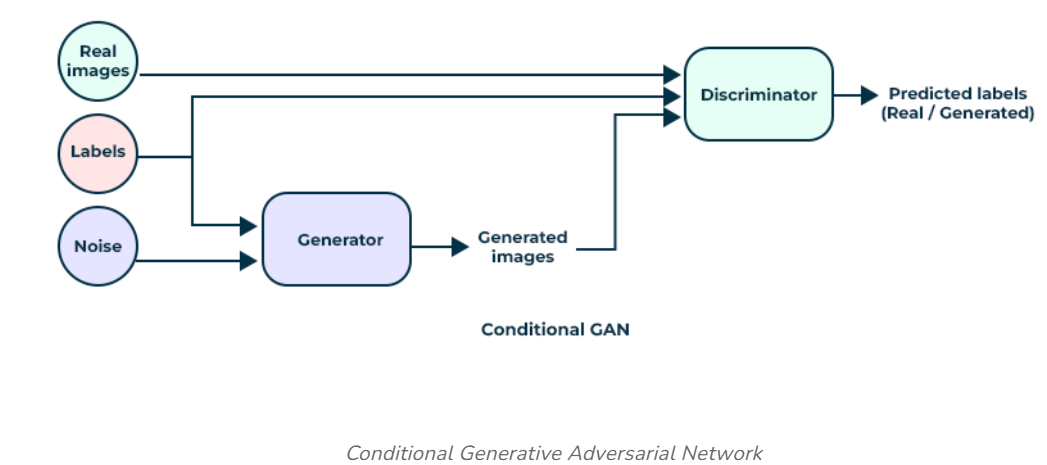

In [13]:
#i)import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [14]:
#ii) Loading the data and variable declaring (CGAN)
# for the dataset, we will first declare some global variables
batch_size = 16
epoch_count = 50
noise_dim = 100
n_class = 10

tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
img_size = 32

# Load the dataset
(X_train, y_train), (_, _) = cifar10.load_data()

# Normalize the data
X_train = (X_train - 127.5) / 127.5

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [25]:
#iii) Visualizing the data
# plotting a random image from the dataset
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

In [26]:
#iv) Defining Loss function and optimizer
#Binary Cross-Entropy Loss for distinguishing betwen real and fake data in GANs

# Define Loss function for Classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
	real_loss = bce_loss(tf.ones_like(real), real)
	fake_loss = bce_loss(tf.zeros_like(fake), fake)
	total_loss = real_loss + fake_loss
	return total_loss

# Generator Loss
def generator_loss(preds):
	return bce_loss(tf.ones_like(preds), preds)

# Optimiser for both Generator and Dsicriminator
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

In [30]:
#v) Building the Generator Model & Discriminator Model
def build_generator():

# label input
	in_label = tf.keras.layers.Input(shape=(1,))

	# create an embedding layer for all the 10 classes in the form of a vector
	# of size 50
	li = tf.keras.layers.Embedding(n_class, 50)(in_label)

	n_nodes = 8 * 8
	li = tf.keras.layers.Dense(n_nodes)(li)
	# reshape the layer
	li = tf.keras.layers.Reshape((8, 8, 1))(li)

	# image generator input
	in_lat = tf.keras.layers.Input(shape=(noise_dim,))

	n_nodes = 128 * 8 * 8
	gen = tf.keras.layers.Dense(n_nodes)(in_lat)
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
	gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

	# merge image gen and label input
	merge = tf.keras.layers.Concatenate()([gen, li])

	gen = tf.keras.layers.Conv2DTranspose(
		128, (4, 4), strides=(2, 2), padding='same')(merge) # 16x16x128
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

	gen = tf.keras.layers.Conv2DTranspose(
		128, (4, 4), strides=(2, 2), padding='same')(gen) # 32x32x128
	gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

	out_layer = tf.keras.layers.Conv2D(
		3, (8, 8), activation='tanh', padding='same')(gen) # 32x32x3

	model = Model([in_lat, in_label], out_layer)
	return model


g_model = build_generator()
g_model.summary()




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8192)           │        827,392 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │            500 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 8192)           │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 64)          │          3,264 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 8, 8, 128)      │              0 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 8, 8, 1)        │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 129)      │              0 │ reshape_4[0][0],       │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 16, 16, 128)    │        264,320 │ concatenate_2[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_transpose_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 32, 32, 128)    │        262,272 │ leaky_re_lu_6[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 3)      │         24,579 │ leaky_re_lu_7[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
def build_discriminator():

  # label input
  in_label = tf.keras.layers.Input(shape=(1,))
  #This vector of size 50 will be learnt by the discriminator
  li = tf.keras.layers.Embedding(n_class, 50)(in_label)

  n_nodes = img_size * img_size
  li = tf.keras.layers.Dense(n_nodes)(li)

  li = tf.keras.layers.Reshape((img_size, img_size, 1))(li)


  # image input
  in_image = tf.keras.layers.Input(shape=(img_size, img_size, 3))

  merge = tf.keras.layers.Concatenate()([in_image, li])


  #We will combine input label with input image and supply as inputs to the model.
  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Flatten()(fe)

  fe = tf.keras.layers.Dropout(0.4)(fe)

  out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)

  # define model the model.
  model = Model([in_image, in_label], out_layer)

  return model


d_model = build_discriminator()
d_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │            500 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1024)        │         52,224 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 32, 32, 1)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 4)      │              0 │ input_layer_3[0][0],   │
│ (Concatenate)             │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │          4,736 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8192)           │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          8,193 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# vi) Compiles the train_step function into a callable TensorFlow graph
@tf.function
def train_step(dataset):

	real_images, real_labels = dataset
	# Sample random points in the latent space and concatenate the labels.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
	generated_images = g_model([random_latent_vectors, real_labels])

	# Train the discriminator.
	with tf.GradientTape() as tape:
		pred_fake = d_model([generated_images, real_labels])
		pred_real = d_model([real_images, real_labels])

		d_loss = discriminator_loss(pred_real, pred_fake)

	grads = tape.gradient(d_loss, d_model.trainable_variables)
	# print(grads)
	d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

	#-----------------------------------------------------------------#

	# Sample random points in the latent space.
	random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

	# Train the generator
	with tf.GradientTape() as tape:
		fake_images = g_model([random_latent_vectors, real_labels])
		predictions = d_model([fake_images, real_labels])
		g_loss = generator_loss(predictions)

	grads = tape.gradient(g_loss, g_model.trainable_variables)
	g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

	return d_loss, g_loss


In [47]:
#vii) Helper function to plot generated images
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in np.arange(10):
        random_noise = tf.random.normal(shape=(num_samples, noise_dim))
        label = tf.ones(num_samples)*l
        gen_imgs = g_model.predict([random_noise, label])
        for j in range(gen_imgs.shape[0]):
            # Corrected indentation for this line
            img = image.array_to_img(gen_imgs[j], scale=True)
            axes[l,j].imshow(img)
            axes[l,j].yaxis.set_ticks([])
            axes[l,j].xaxis.set_ticks([])

            if j ==0:
                axes[l,j].set_ylabel(tags[l])
    plt.show()

Epoch:  50


100%|██████████| 3125/3125 [00:51<00:00, 60.88it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Epoch: 0 -- Generator Loss: 0.8889403343200684, Discriminator Loss: 1.2920066118240356

Took 54.80031418800354 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [01:21<00:00, 38.15it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


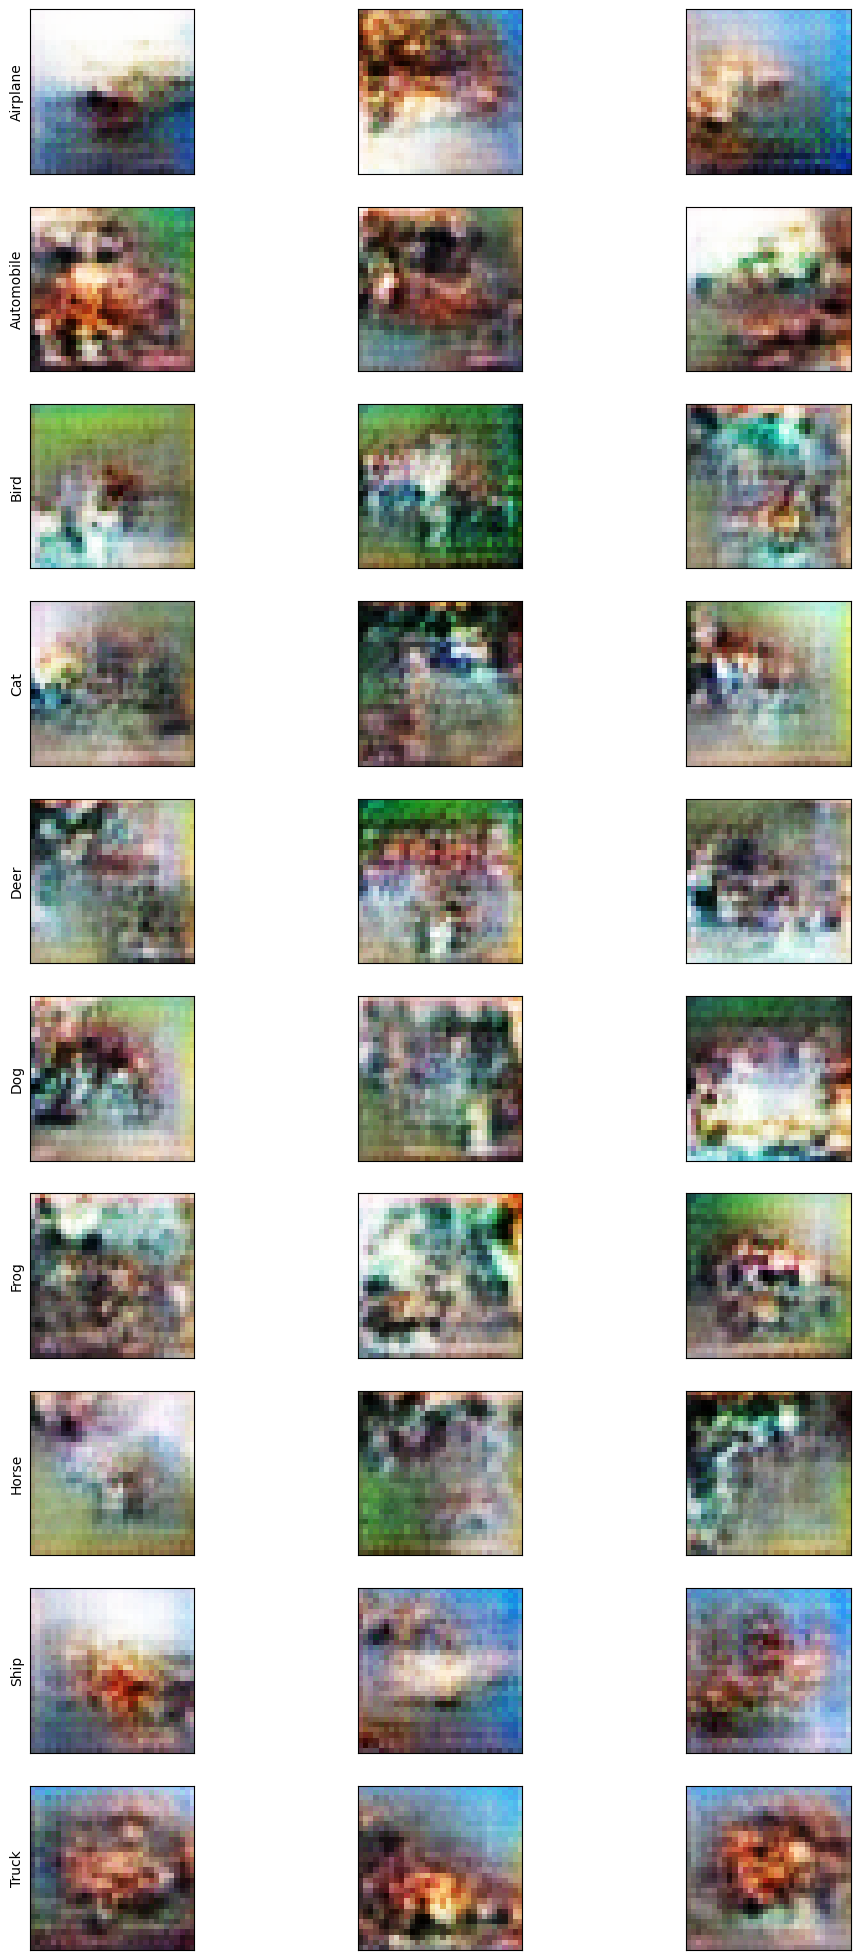

Epoch: 1 -- Generator Loss: 0.8714475035667419, Discriminator Loss: 1.29551362991333

Took 85.40583729743958 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 73.25it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


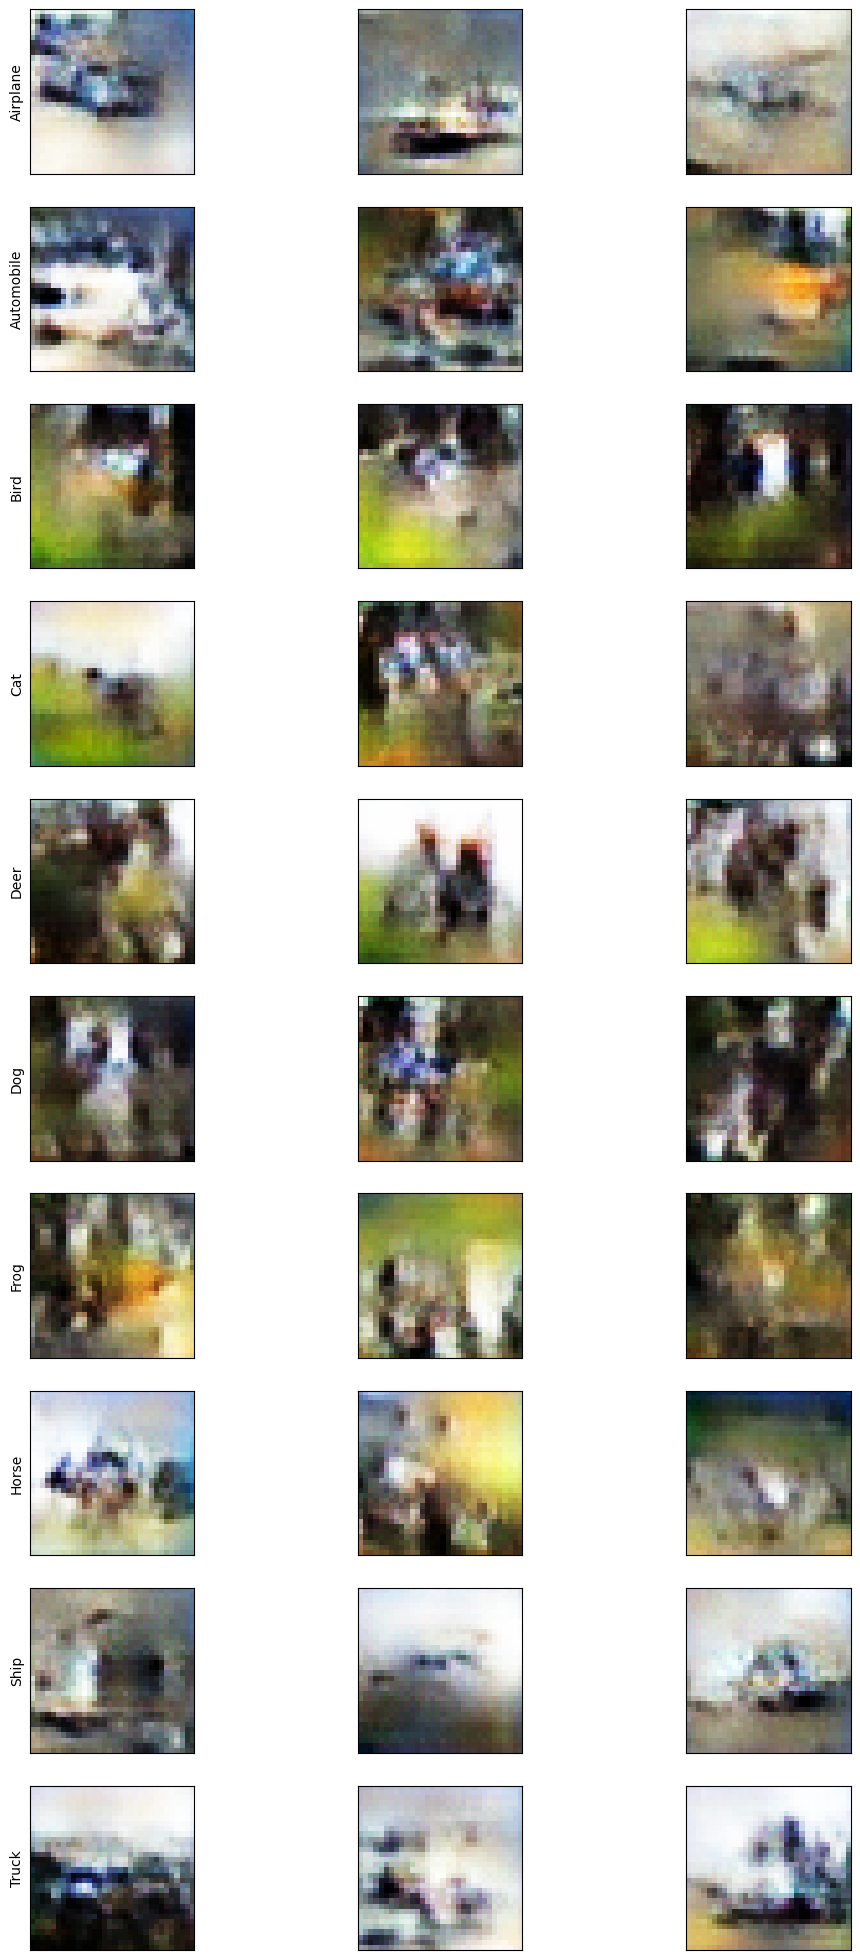

Epoch: 2 -- Generator Loss: 0.8203220963478088, Discriminator Loss: 1.3276567459106445

Took 45.418354749679565 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 74.33it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


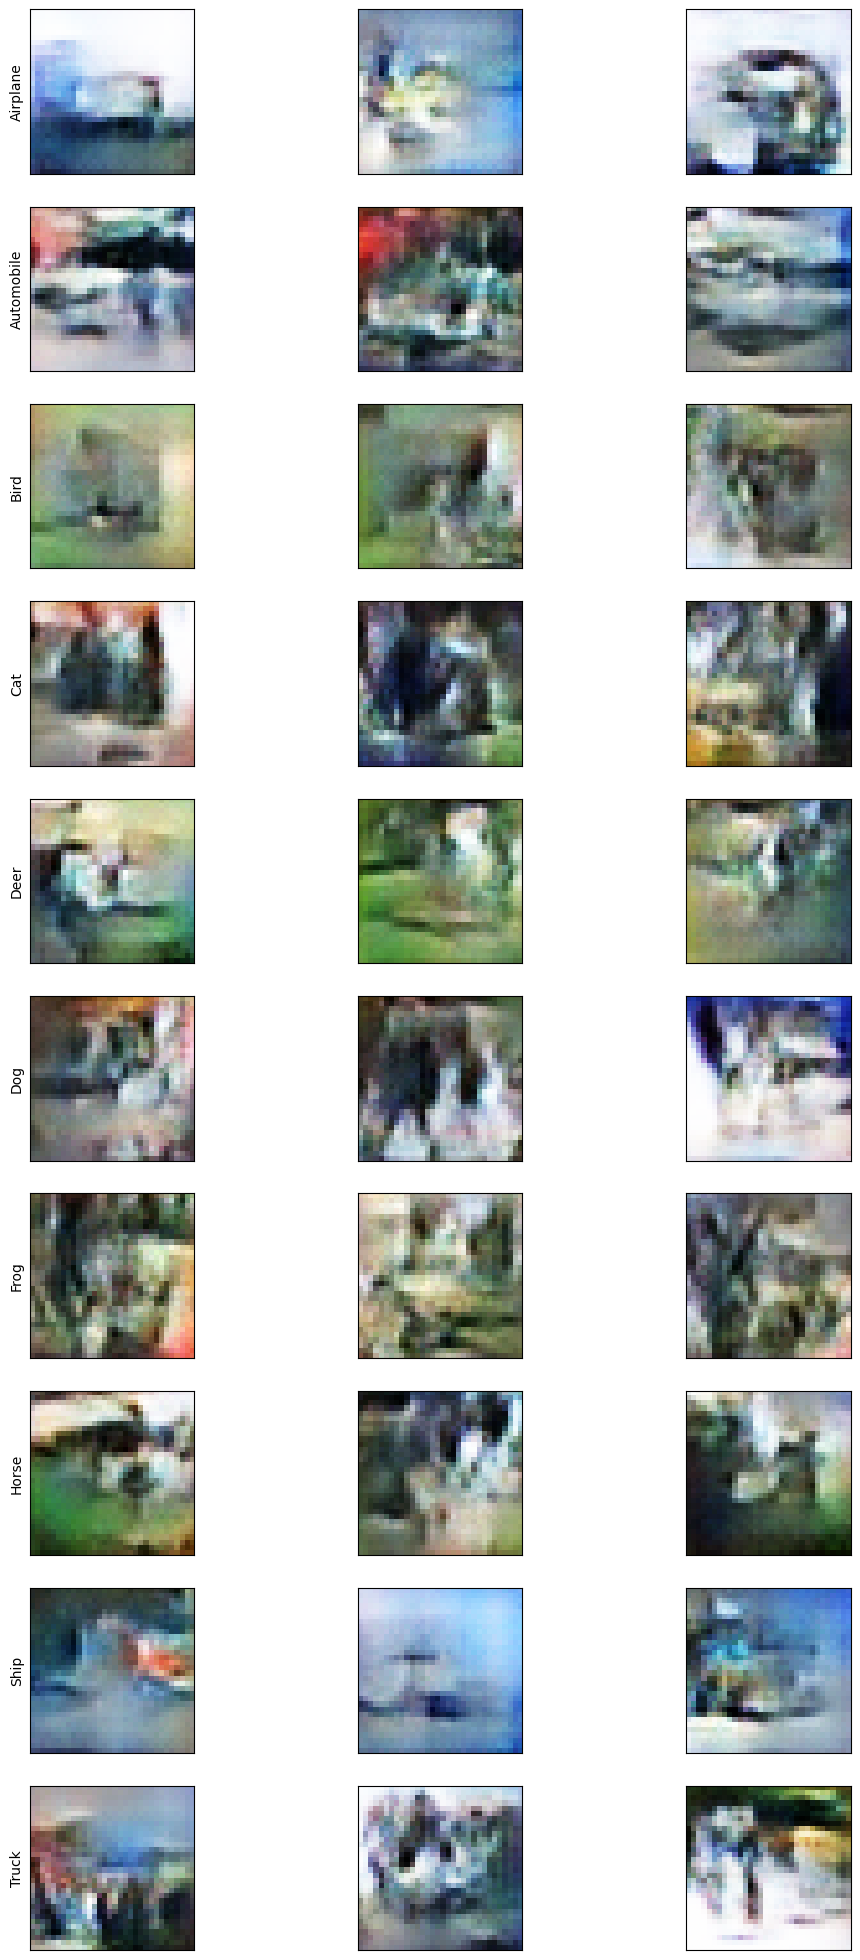

Epoch: 3 -- Generator Loss: 0.787704586982727, Discriminator Loss: 1.3489079475402832

Took 46.18041014671326 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 73.32it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


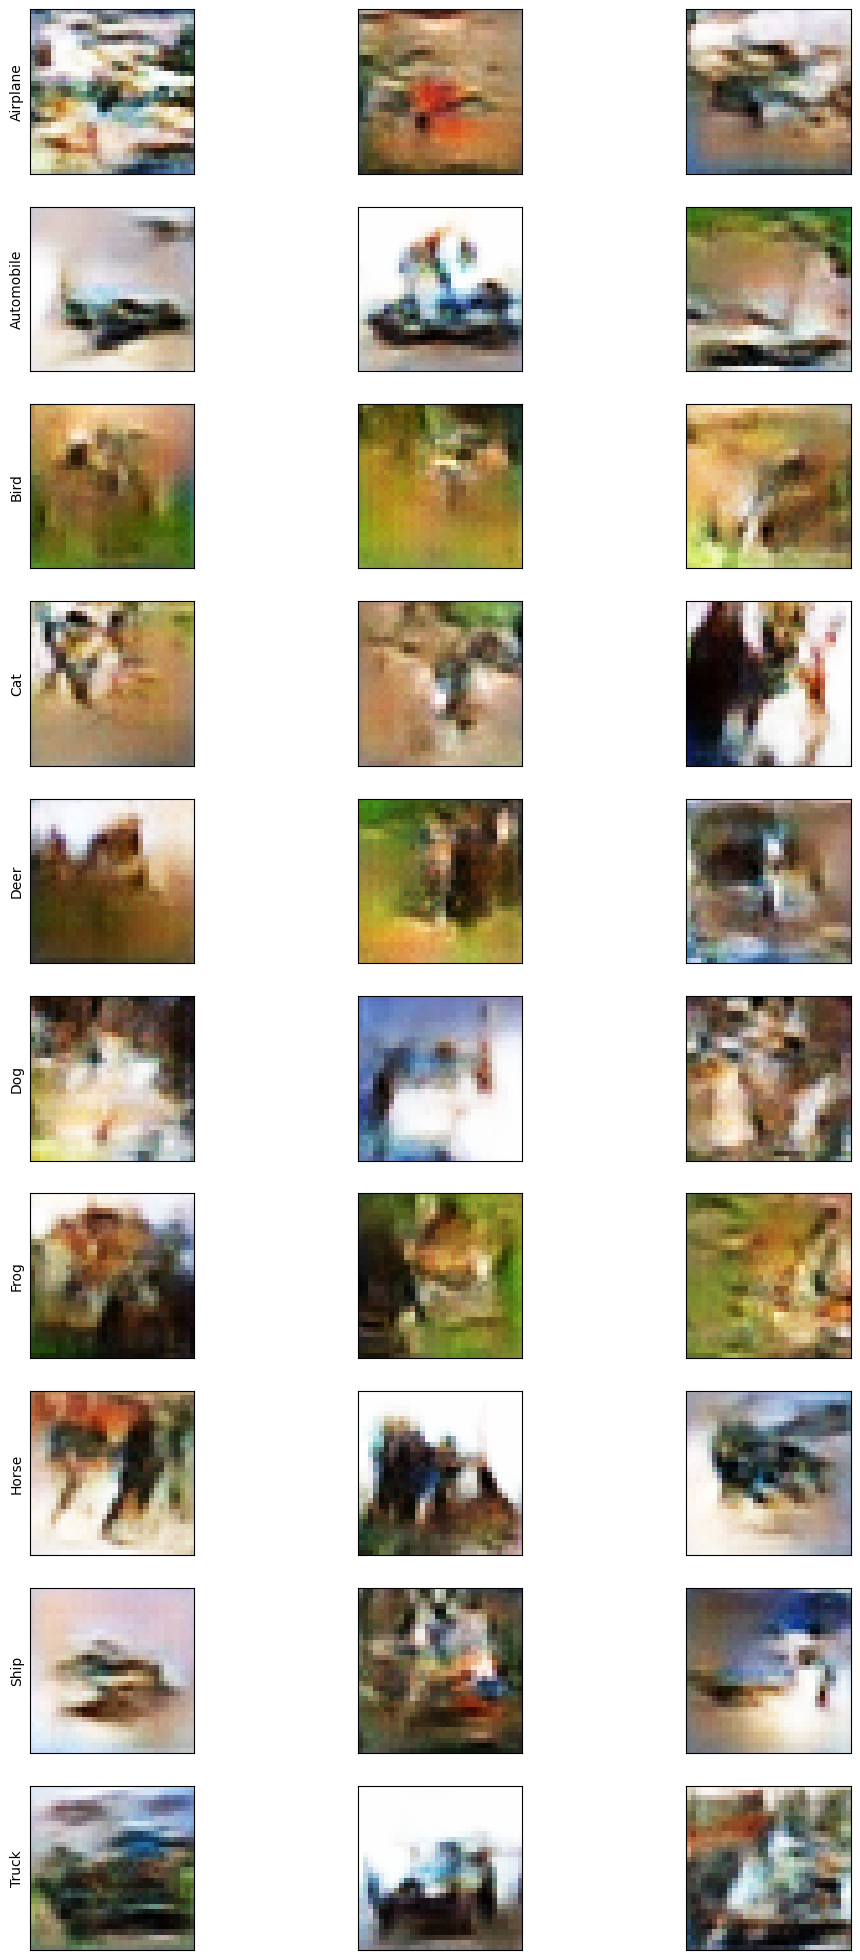

Epoch: 4 -- Generator Loss: 0.7833238244056702, Discriminator Loss: 1.3467103242874146

Took 45.50536131858826 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 73.53it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


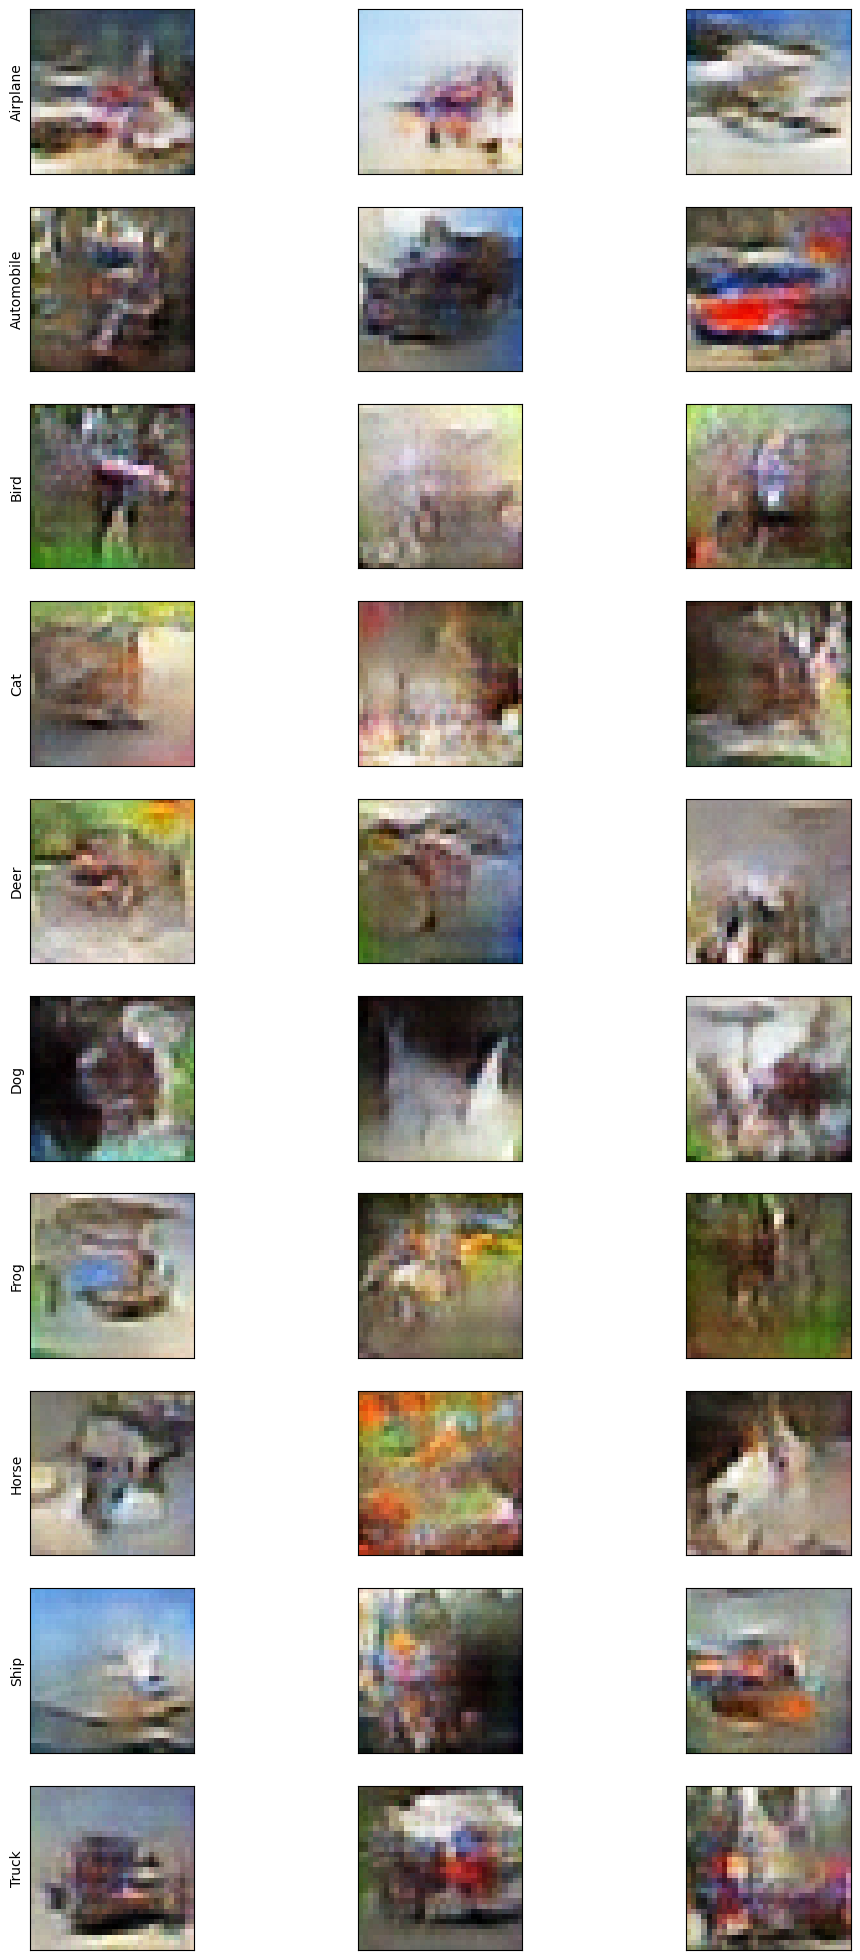

Epoch: 5 -- Generator Loss: 0.765819787979126, Discriminator Loss: 1.3601266145706177

Took 46.07265114784241 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 73.72it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


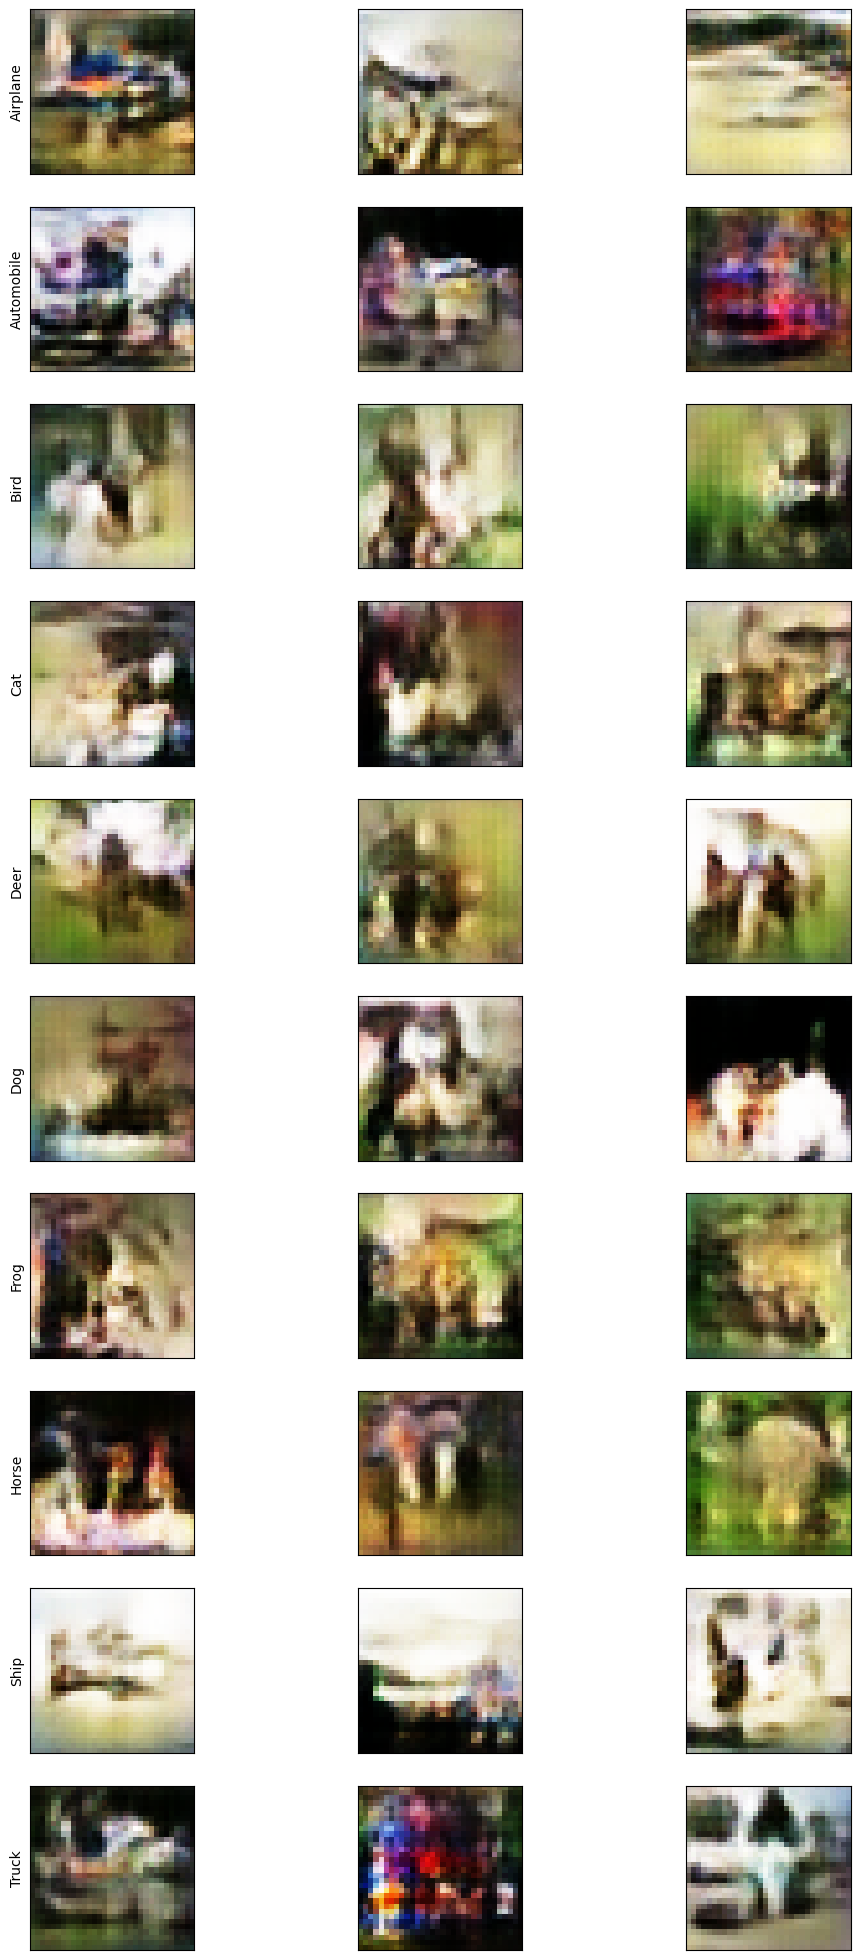

Epoch: 6 -- Generator Loss: 0.7558525800704956, Discriminator Loss: 1.3691874742507935

Took 45.27340793609619 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 72.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


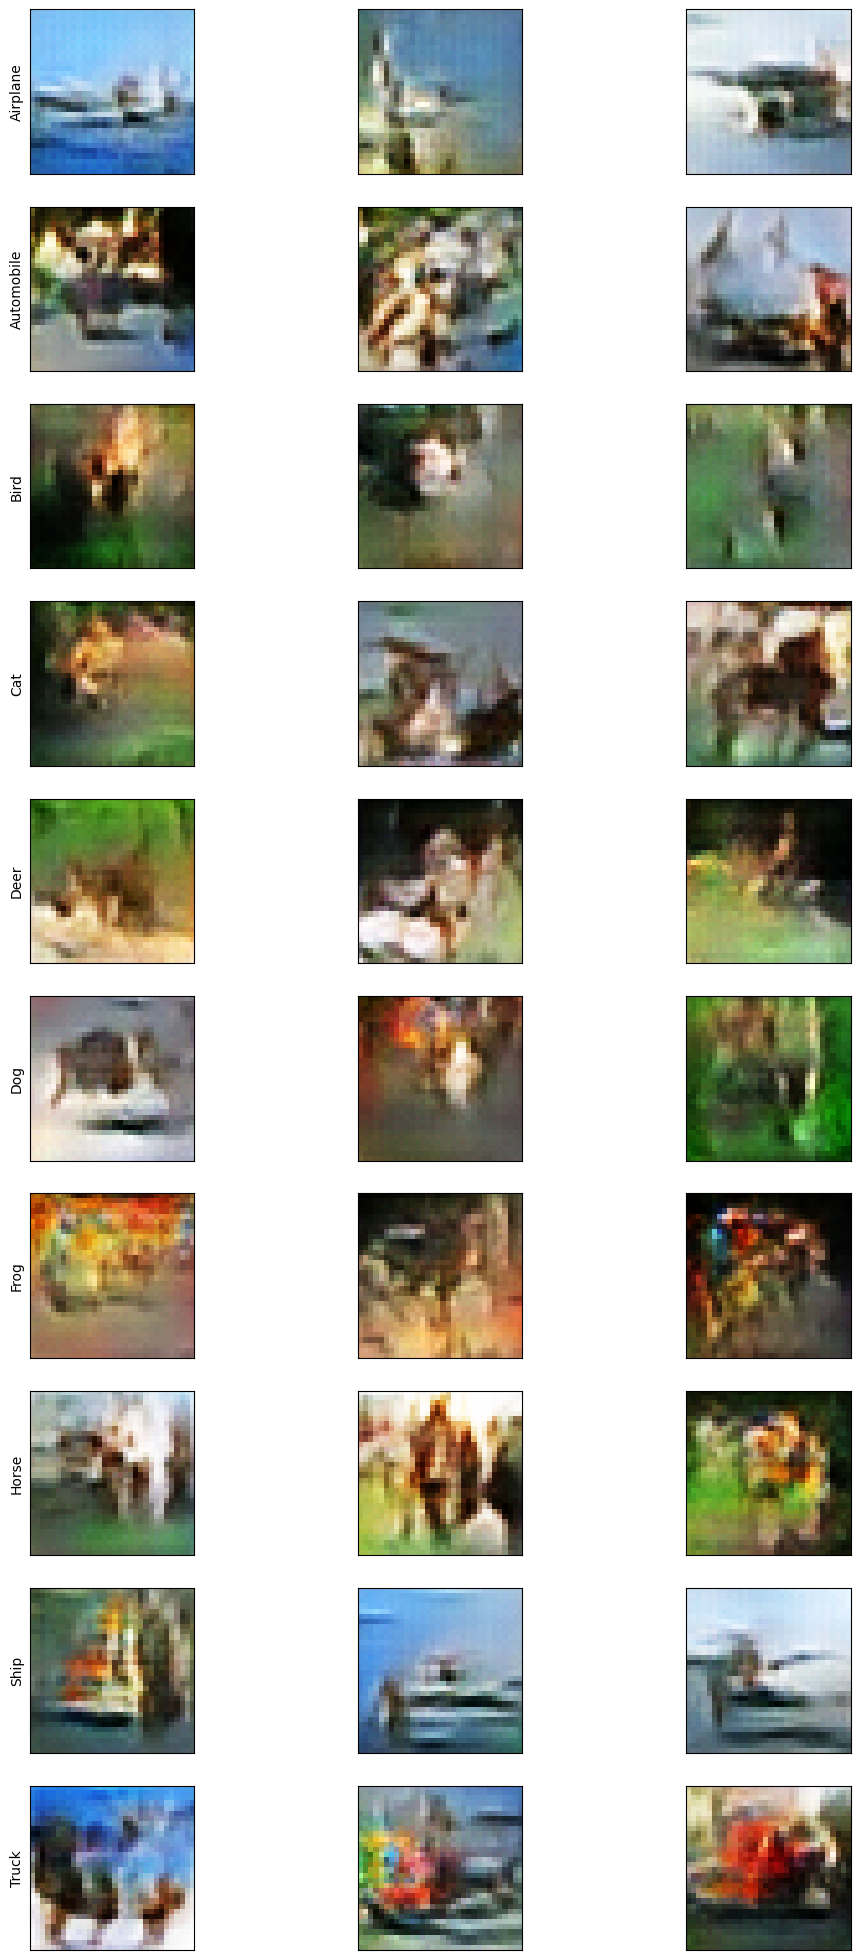

Epoch: 7 -- Generator Loss: 0.7580506801605225, Discriminator Loss: 1.3662371635437012

Took 46.156548738479614 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 72.87it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


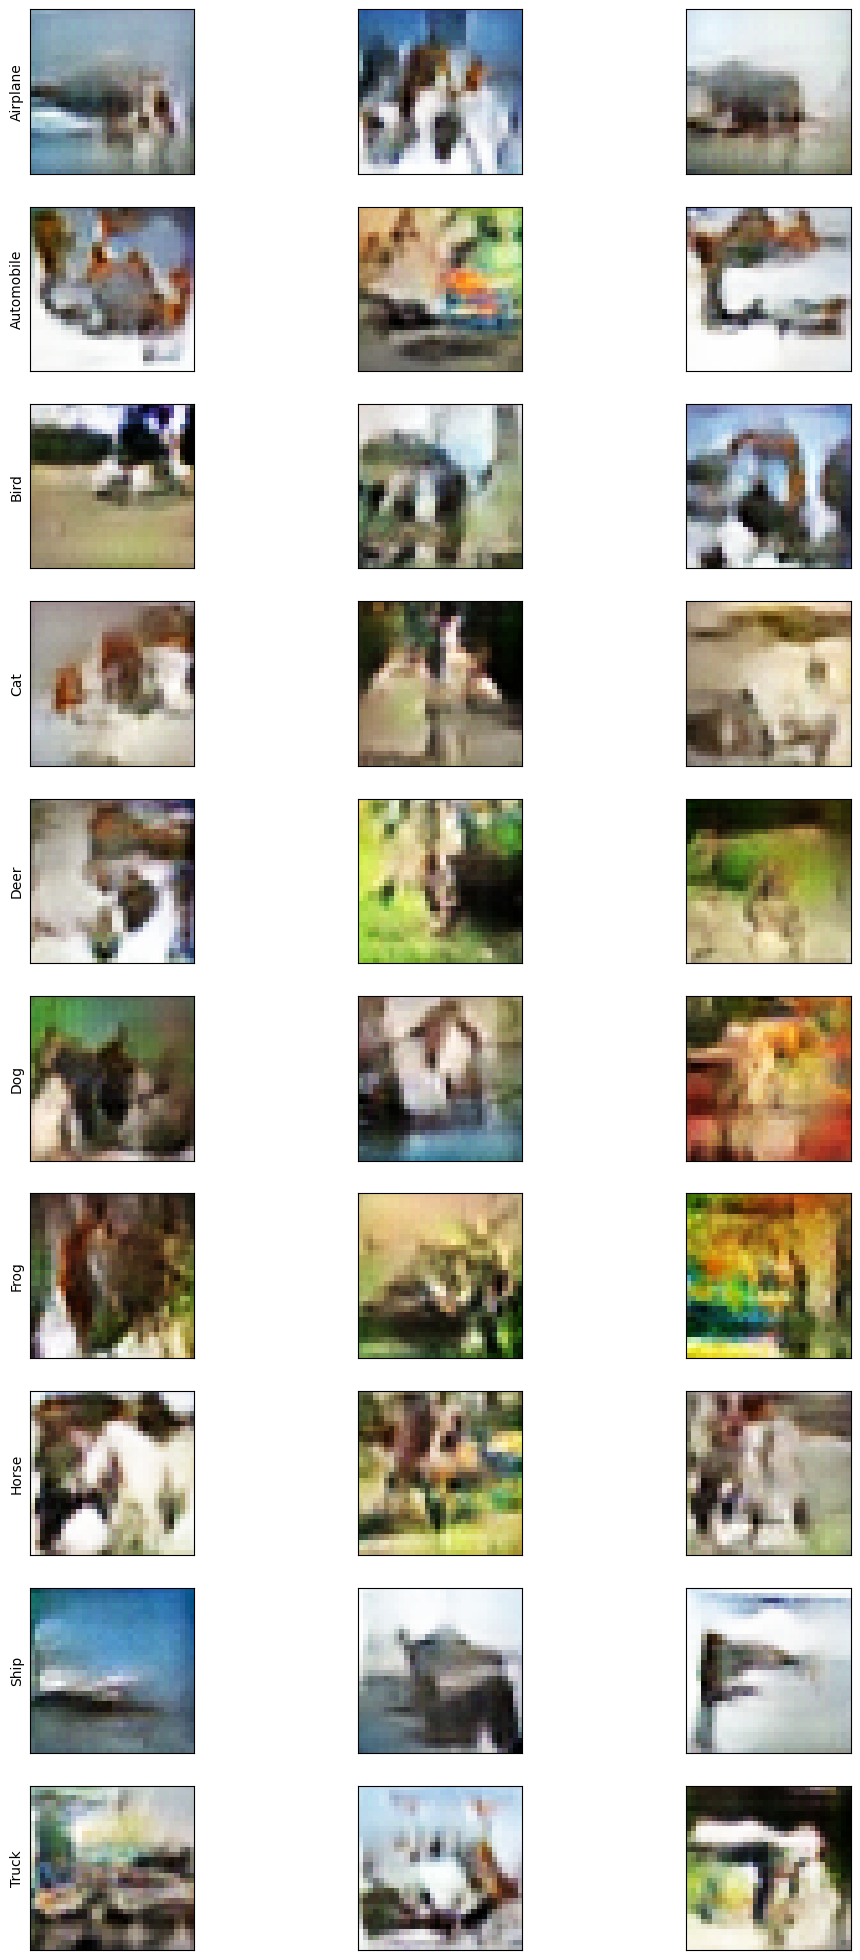

Epoch: 8 -- Generator Loss: 0.7579864263534546, Discriminator Loss: 1.363754391670227

Took 46.23731446266174 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:43<00:00, 72.49it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


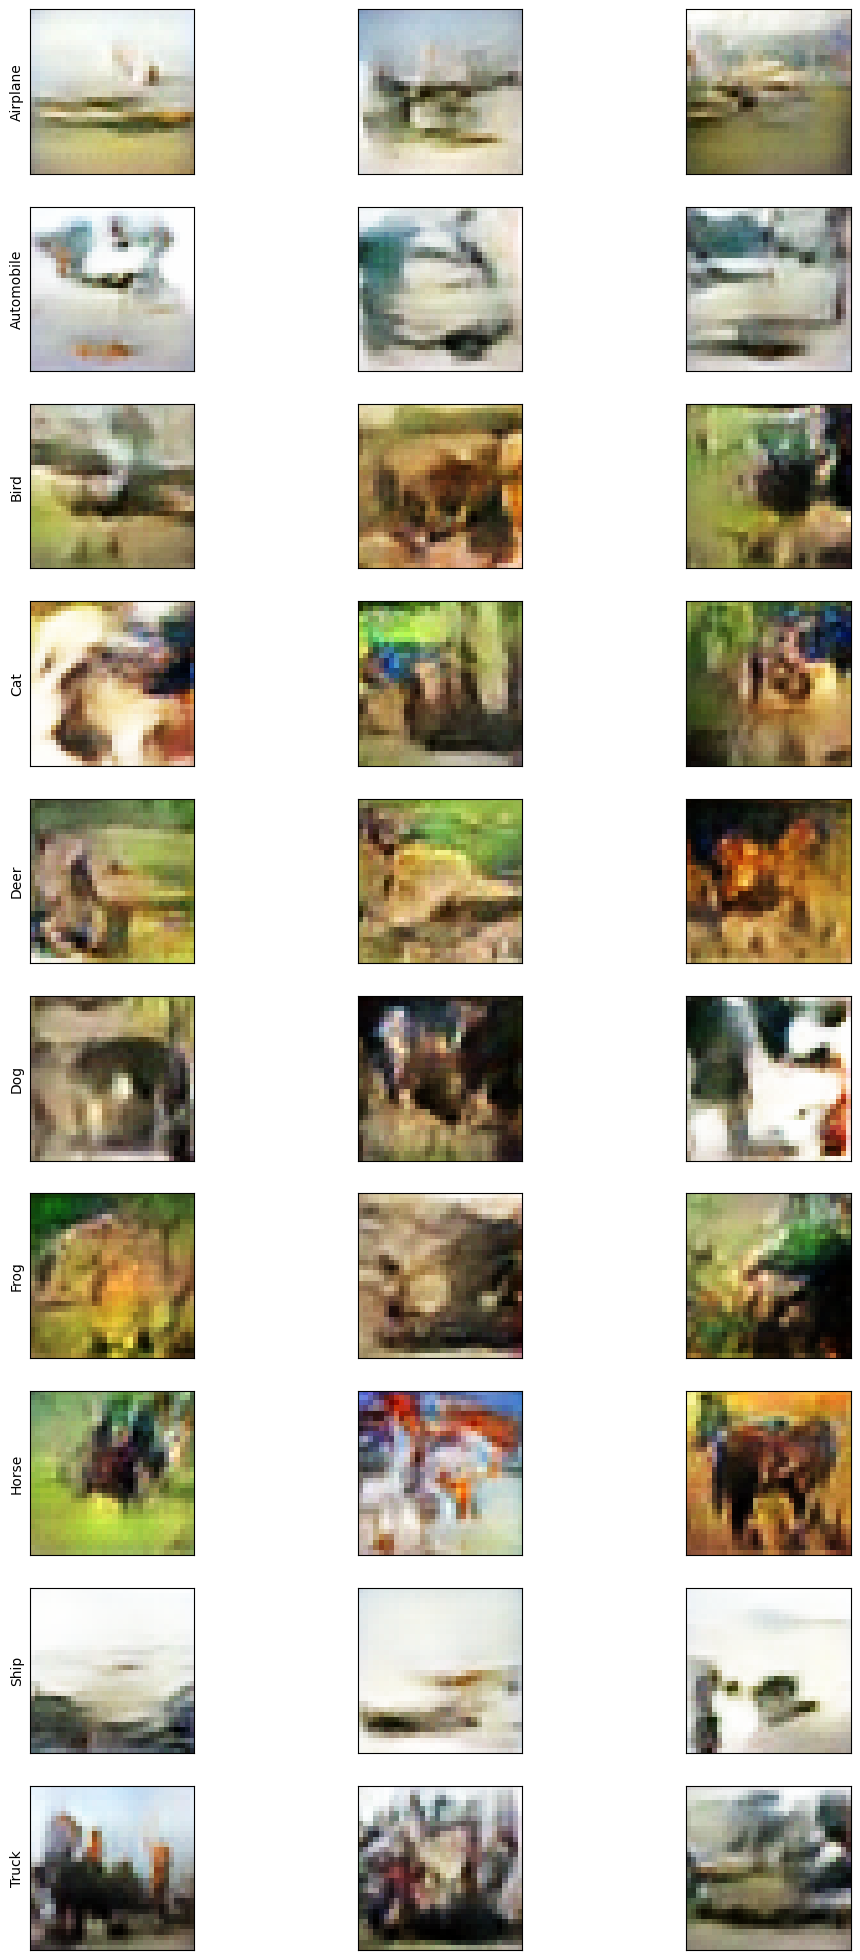

Epoch: 9 -- Generator Loss: 0.758812665939331, Discriminator Loss: 1.3623756170272827

Took 46.484440326690674 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 72.97it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


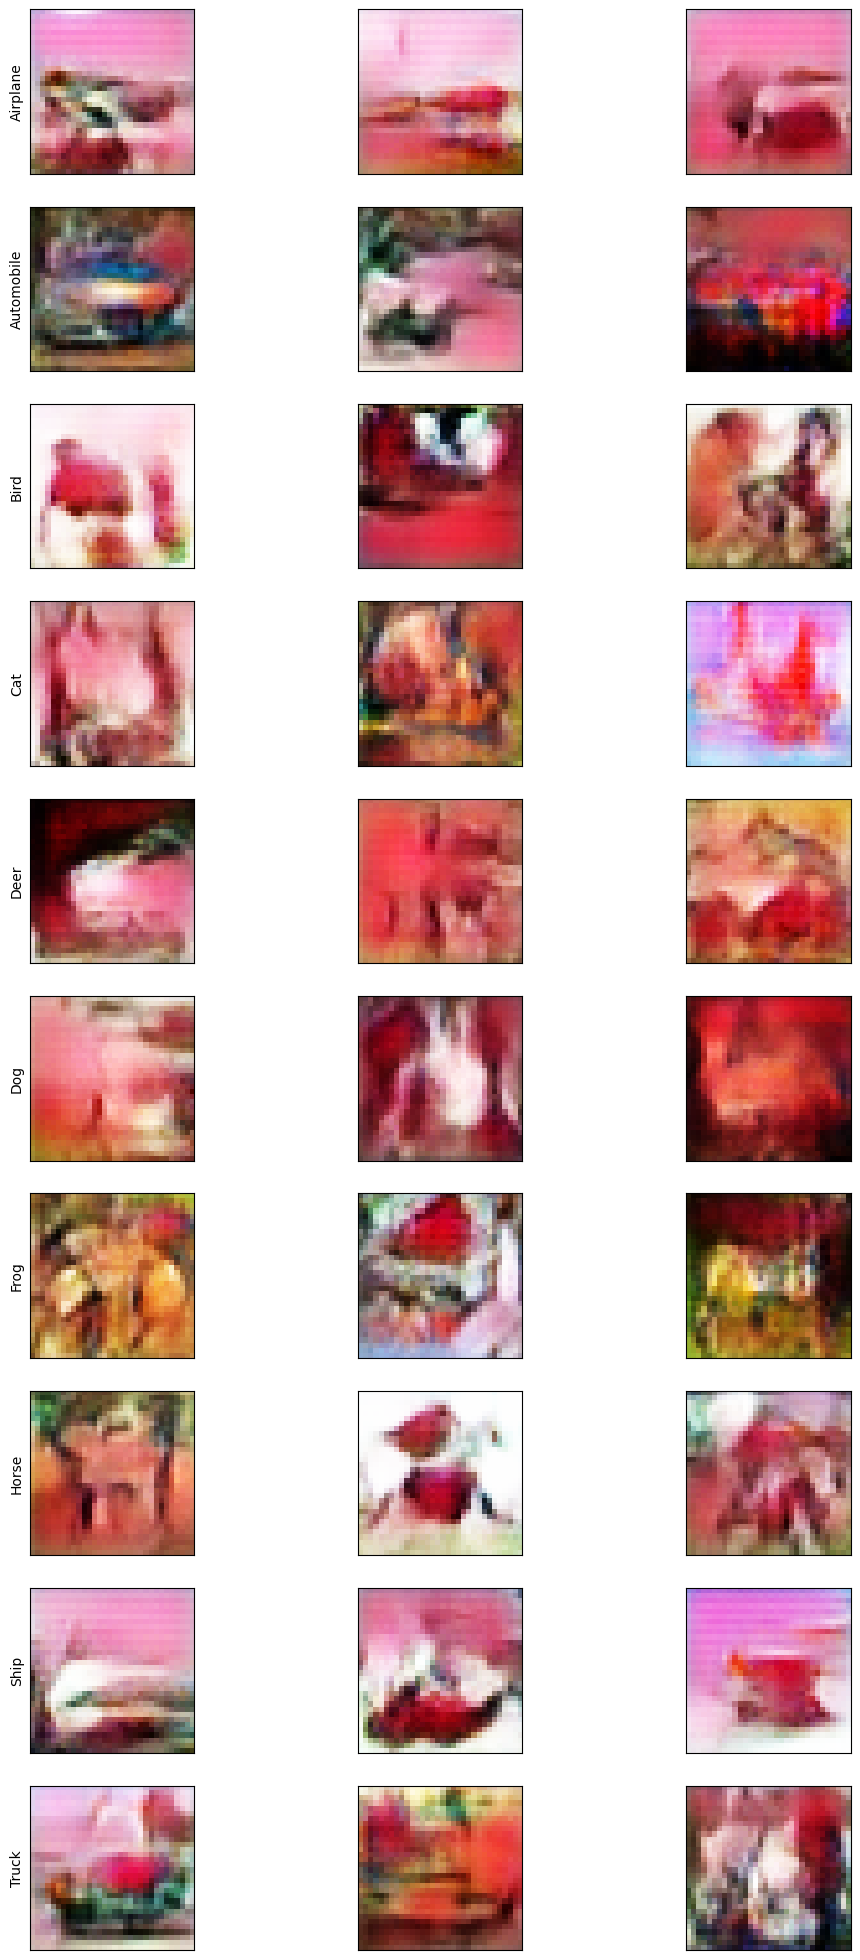

Epoch: 10 -- Generator Loss: 0.7569007277488708, Discriminator Loss: 1.3626117706298828

Took 46.96448087692261 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:43<00:00, 72.22it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


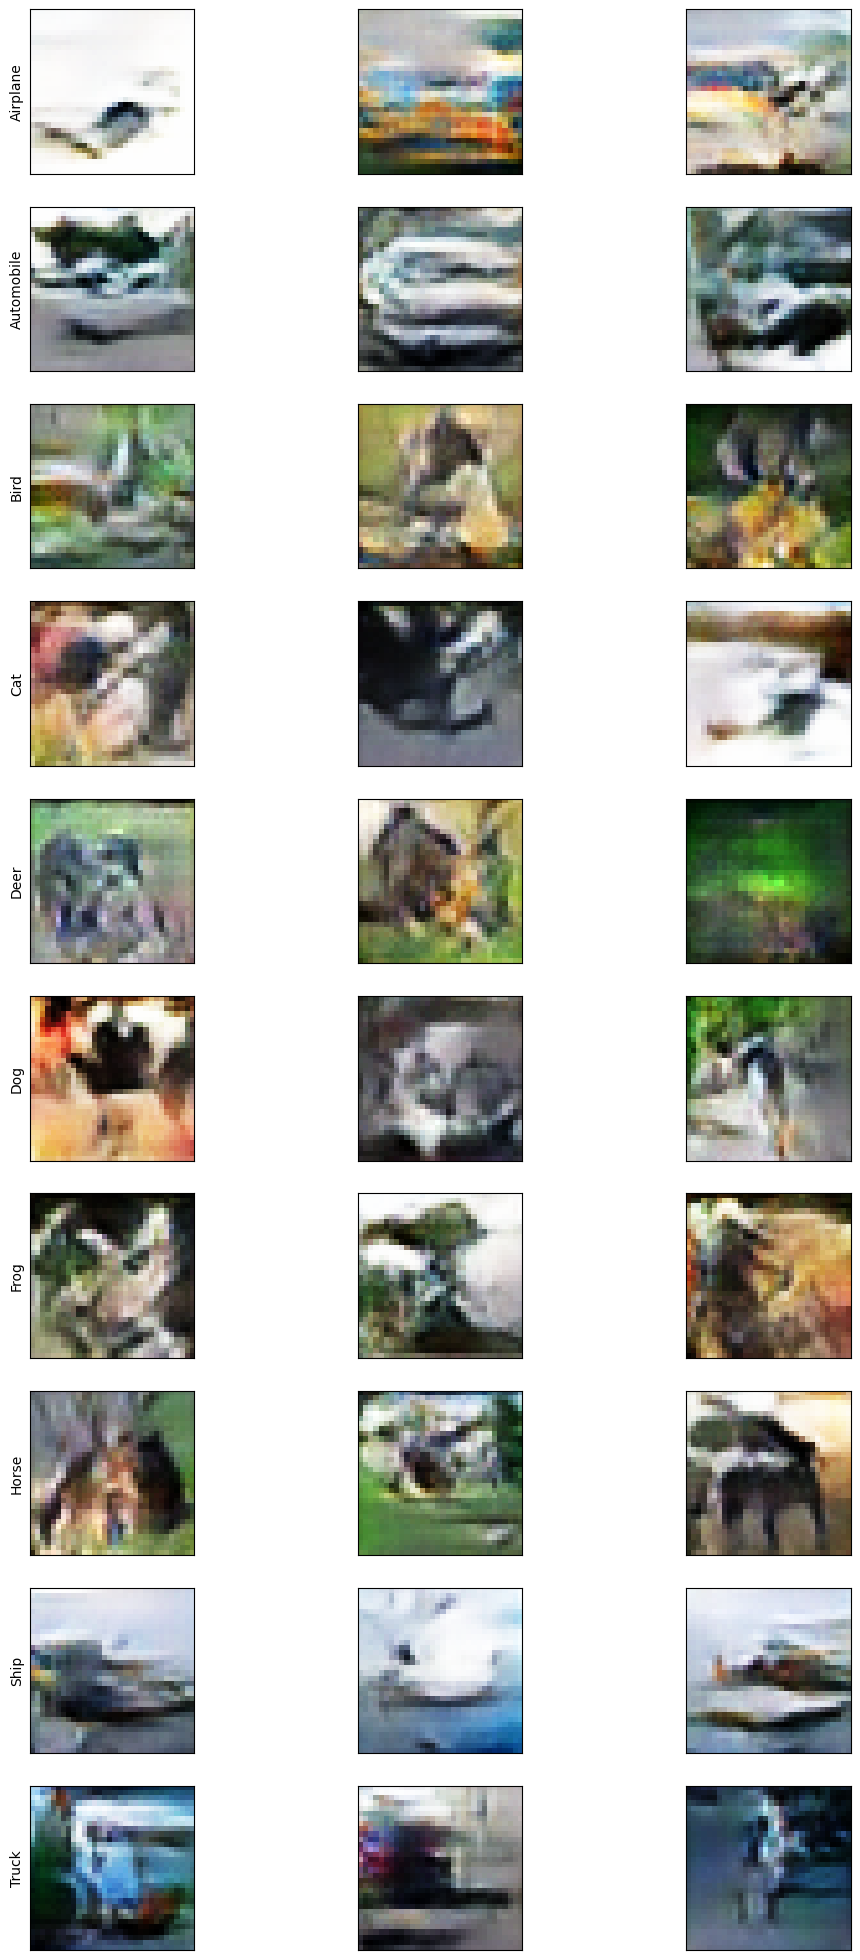

Epoch: 11 -- Generator Loss: 0.7545903921127319, Discriminator Loss: 1.3645434379577637

Took 46.25362944602966 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 72.81it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


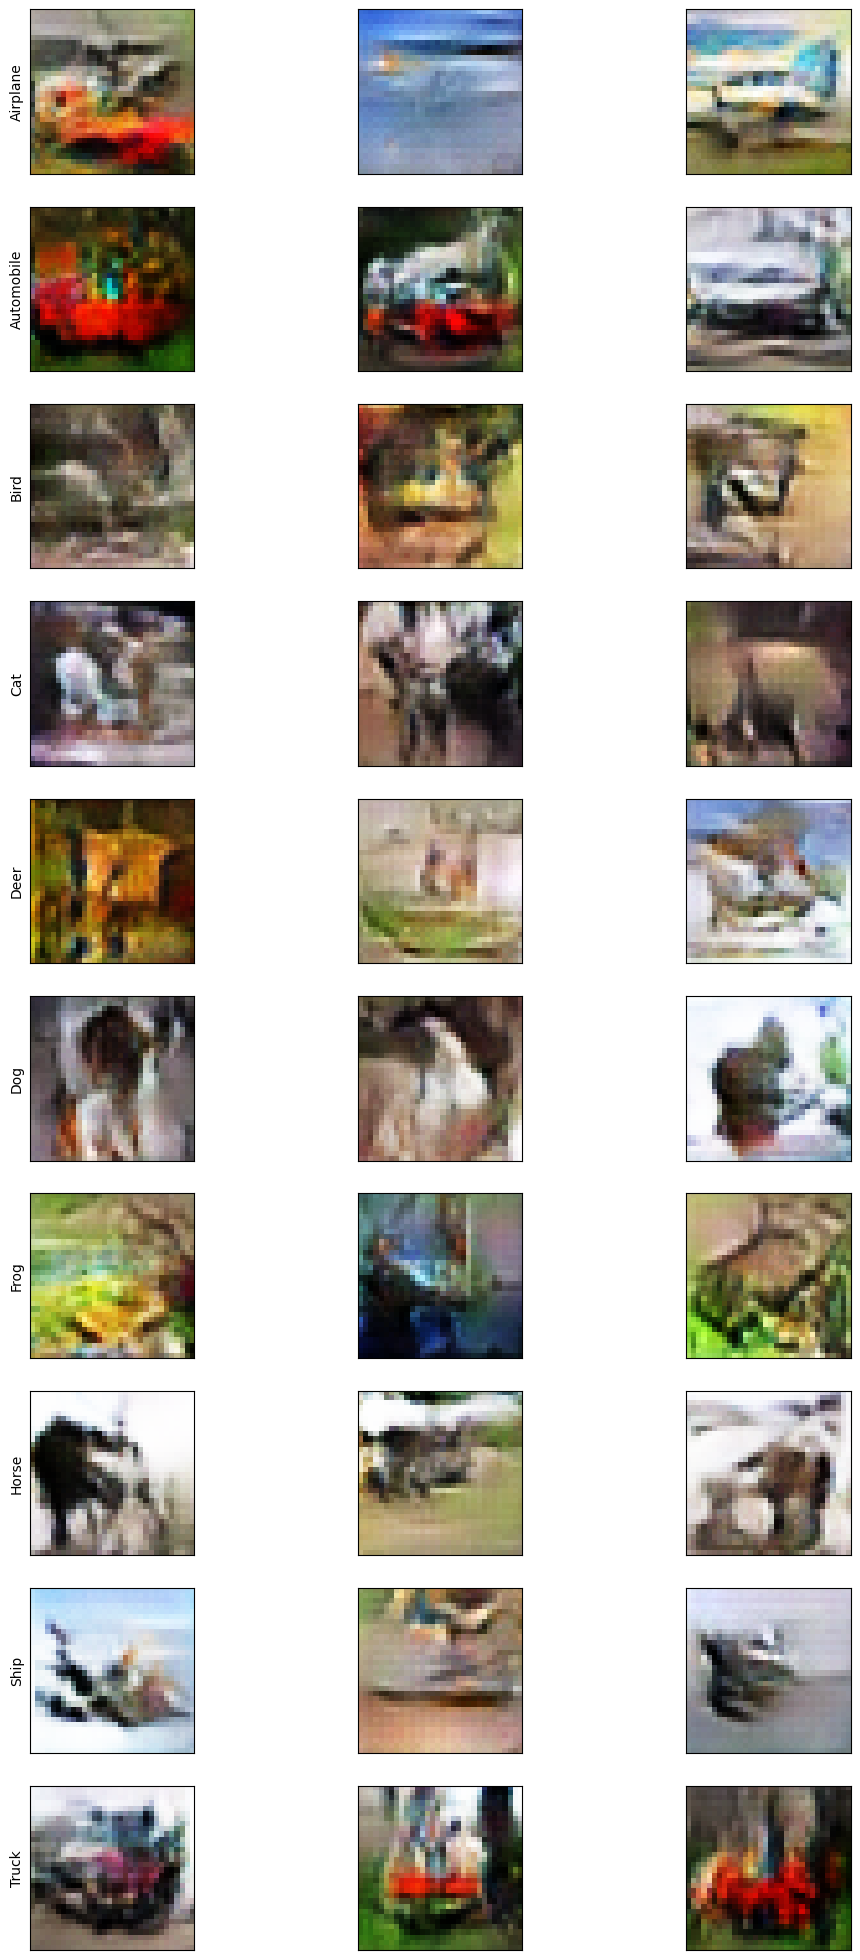

Epoch: 12 -- Generator Loss: 0.7532027363777161, Discriminator Loss: 1.3648629188537598

Took 47.286797285079956 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 72.74it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


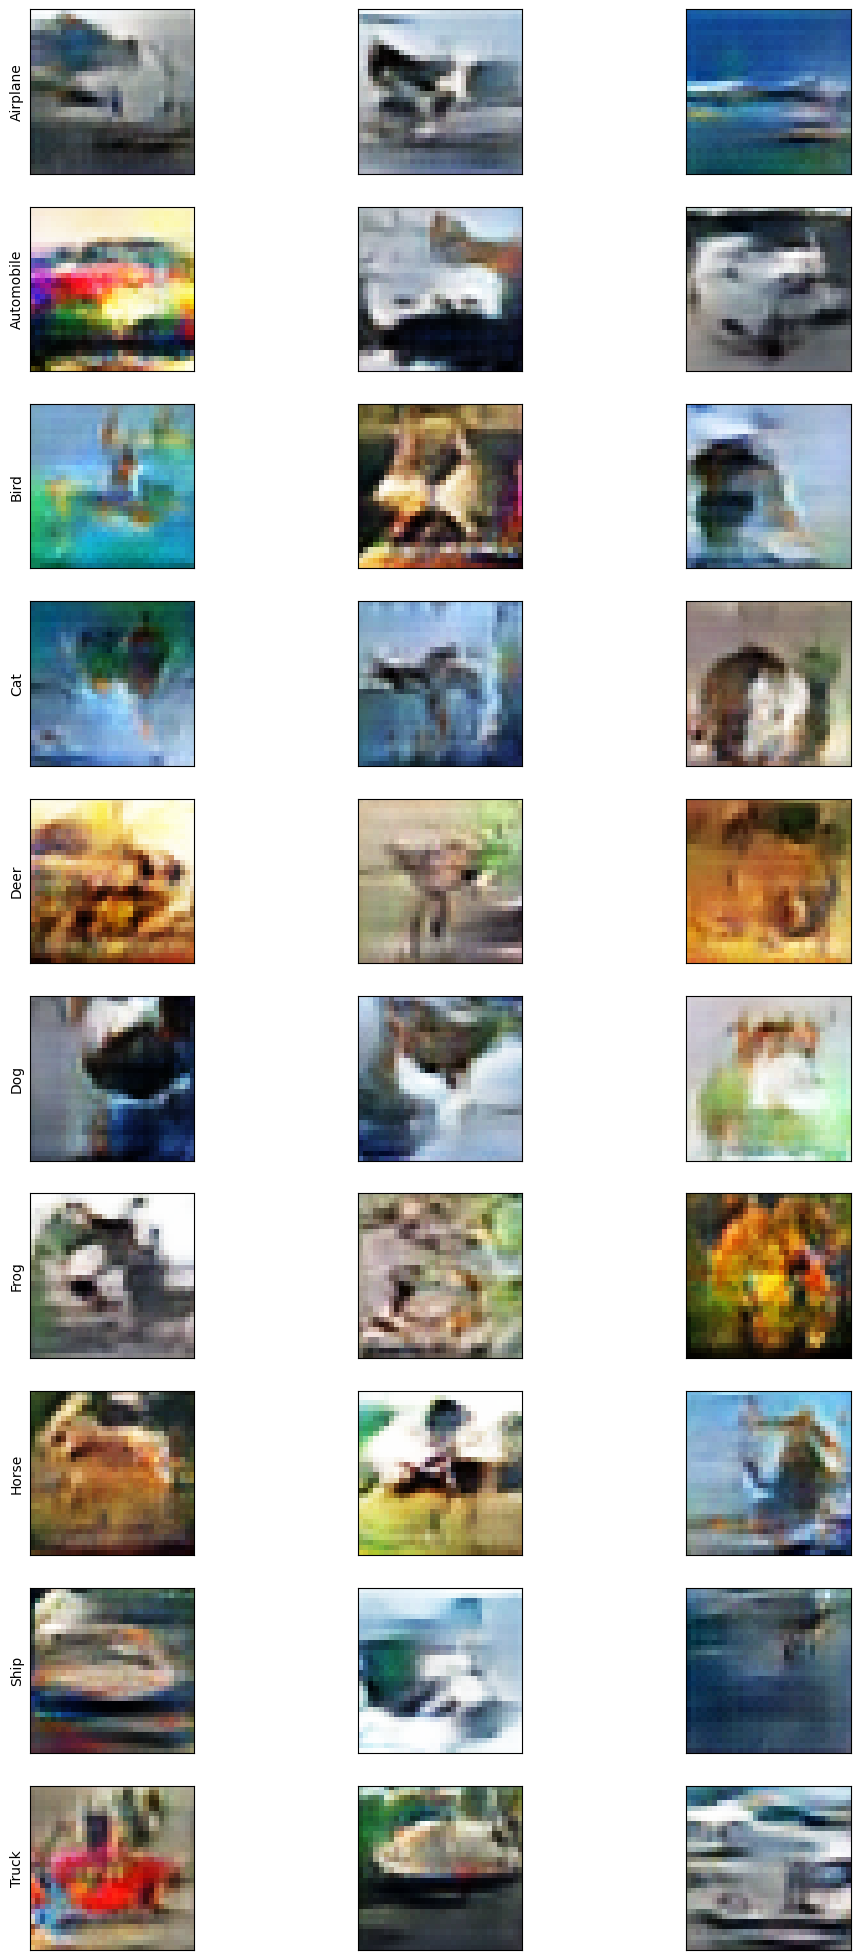

Epoch: 13 -- Generator Loss: 0.7535384297370911, Discriminator Loss: 1.363144874572754

Took 45.98231649398804 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:43<00:00, 72.55it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


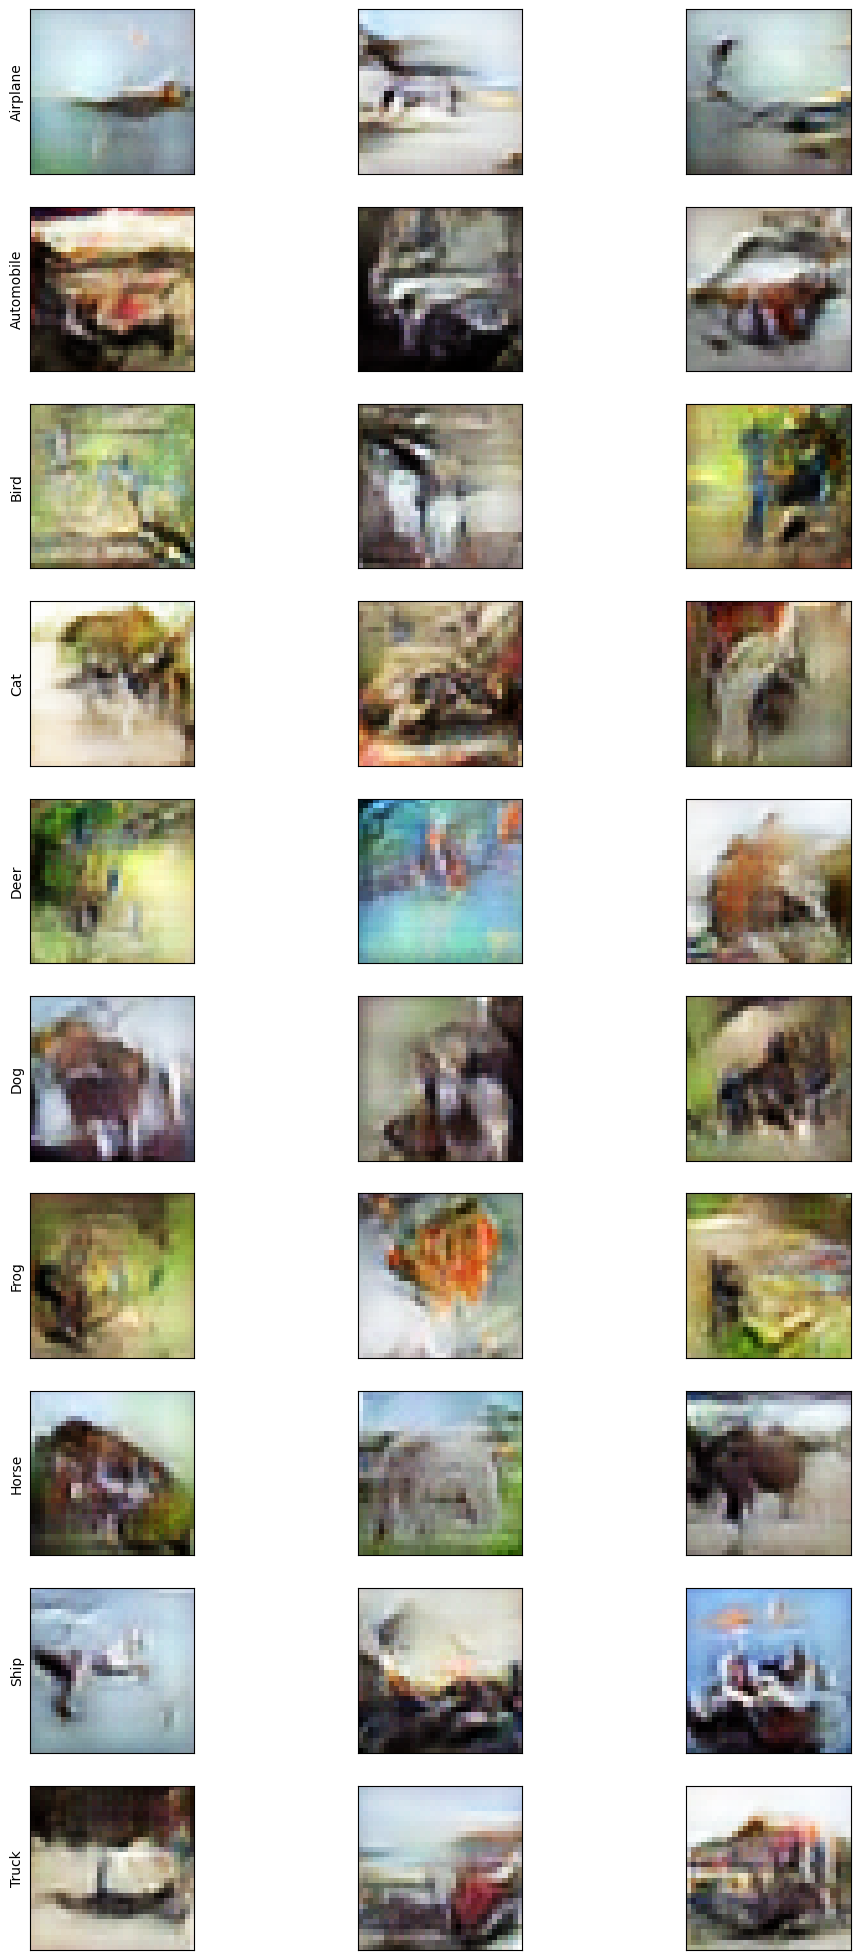

Epoch: 14 -- Generator Loss: 0.7521223425865173, Discriminator Loss: 1.3627009391784668

Took 47.24563431739807 seconds. 


Epoch:  50


 91%|█████████ | 2846/3125 [00:39<00:03, 72.20it/s]


KeyboardInterrupt: 

In [48]:
#viii) Training the Model and Visualize the Output

def train(dataset, epochs=epoch_count):

	for epoch in range(epochs):
		print('Epoch: ', epochs)
		d_loss_list = []
		g_loss_list = []
		q_loss_list = []
		start = time.time()

		itern = 0
		for image_batch in tqdm(dataset):
			d_loss, g_loss = train_step(image_batch)
			d_loss_list.append(d_loss)
			g_loss_list.append(g_loss)
			itern=itern+1

		show_samples(3, n_class, g_model)

		print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
		print (f'Took {time.time()-start} seconds. \n\n')


train(dataset, epochs=epoch_count)


#**3) Deep Convolutional GAN (DCGAN):**
Deep Convolutional GAN (DCGAN) Uses **ConvNets instead of MLPs**, with convolutional strides replacing max pooling and no fully connected layers




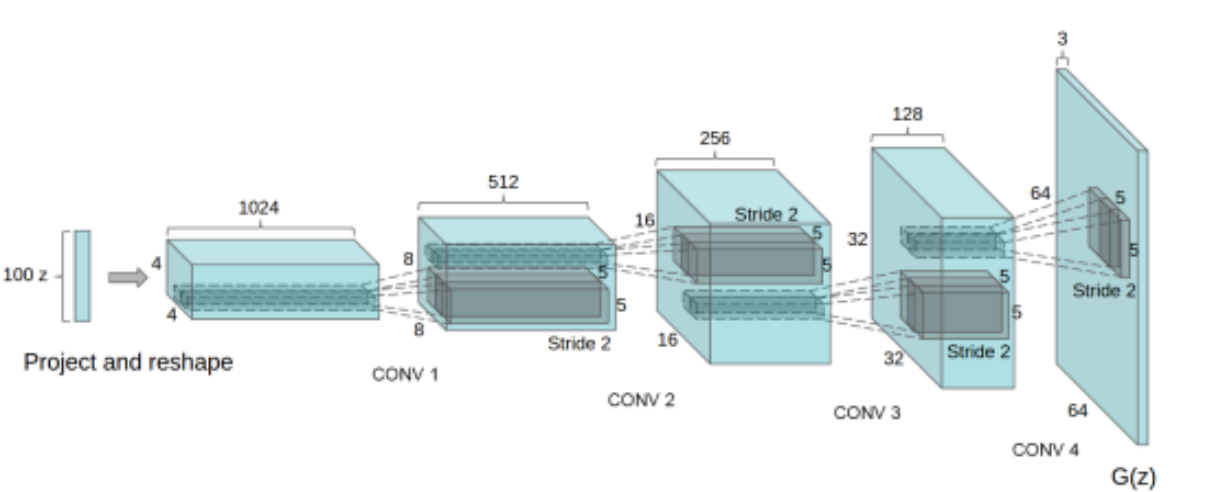



In [1]:
#i) Implementation

# code % matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

# Check tensorflow version
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.17.0


In [2]:
#ii)Dateset and scaling

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

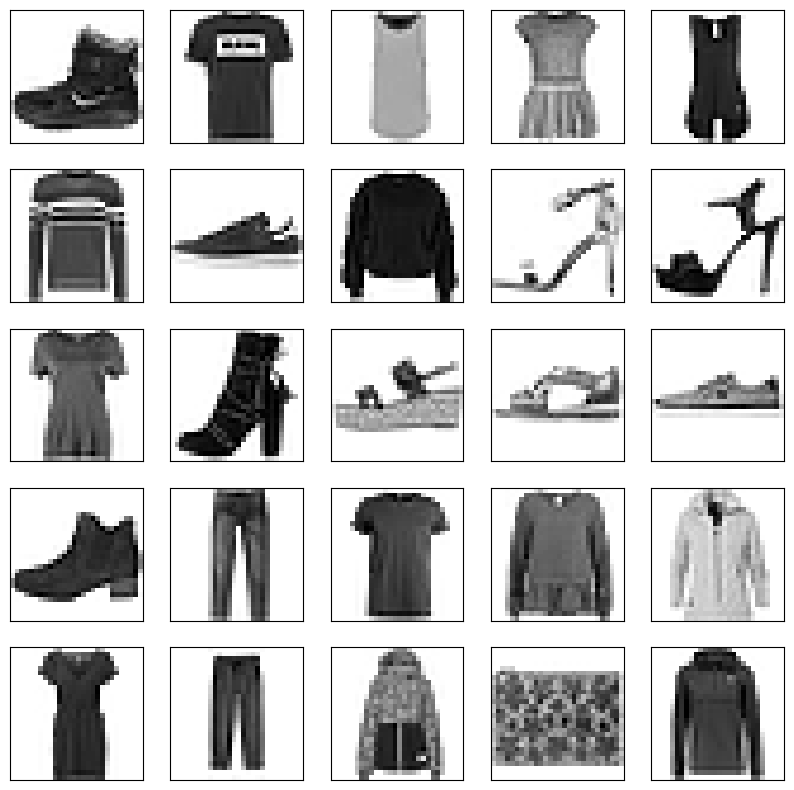

In [3]:
#iii) We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
	plt.subplot(5, 5, i + 1)
	plt.xticks([])
	plt.yticks([])
	plt.grid(False)
	plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [4]:
#iv) code
batch_size = 32
# This dataset fills a buffer with buffer_size elements,
# then randomly samples elements from this buffer,
# replacing the selected elements with new elements.
def create_batch(x_train):
  dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
  # Combines consecutive elements of this dataset into batches.

  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  # Creates a Dataset that prefetches elements from this dataset
  return dataset

In [6]:
#v) generator code
num_features = 100

generator = keras.models.Sequential([
	keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
	keras.layers.Reshape([7, 7, 128]),
	keras.layers.BatchNormalization(),
	keras.layers.Conv2DTranspose(
		64, (5, 5), (2, 2), padding ="same", activation ="selu"),
	keras.layers.BatchNormalization(),
	keras.layers.Conv2DTranspose(
		1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 840,705 (3.21 MB)

 Trainable params: 840,321 (3.21 MB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
#vi) Discriminator

discriminator = keras.models.Sequential([
	keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
	keras.layers.LeakyReLU(0.2),
	keras.layers.Dropout(0.3),
	keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
	keras.layers.LeakyReLU(0.2),
	keras.layers.Dropout(0.3),
	keras.layers.Flatten(),
	keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#vii) compile discriminator using binary cross entropy loss and adam optimizer
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam")
# make discriminator no-trainable as of now
discriminator.trainable = False
# Combine both generator and discriminator
gan = keras.models.Sequential([generator, discriminator])
# compile generator using binary cross entropy loss and adam optimizer

gan.compile(loss ="binary_crossentropy", optimizer ="adam")


In [10]:
#viii) Training DCGAN model

seed = tf.random.normal(shape =[batch_size, 100])

def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
	generator, discriminator = gan.layers
	for epoch in tqdm(range(epochs)):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# create a random noise of sizebatch_size * 100
			# to passit into the generator
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)

			# take batch of generated image and real image and
			# use them to train the discriminator
			X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
			y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
			discriminator.trainable = True
			discriminator.train_on_batch(X_fake_and_real, y1)

			# Here we will be training our GAN model, in this step
			# we pass noise that uses generatortogenerate the image
			# and pass it with labels as [1] So, it can fool the discriminator
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			gan.train_on_batch(noise, y2)

			# generate images for the GIF as we go
			generate_and_save_images(generator, epoch + 1, seed)

	generate_and_save_images(generator, epochs, seed)


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10


<ipython-input-13-d710308d4e89>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize =(10, 10))
  0%|          | 0/10 [02:54<?, ?it/s]


KeyboardInterrupt: 

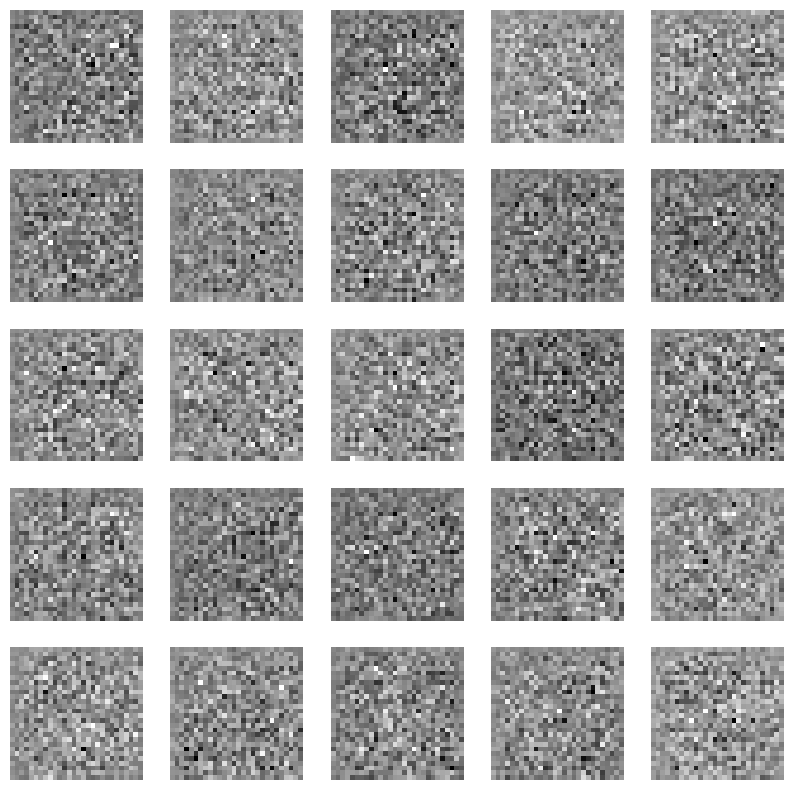

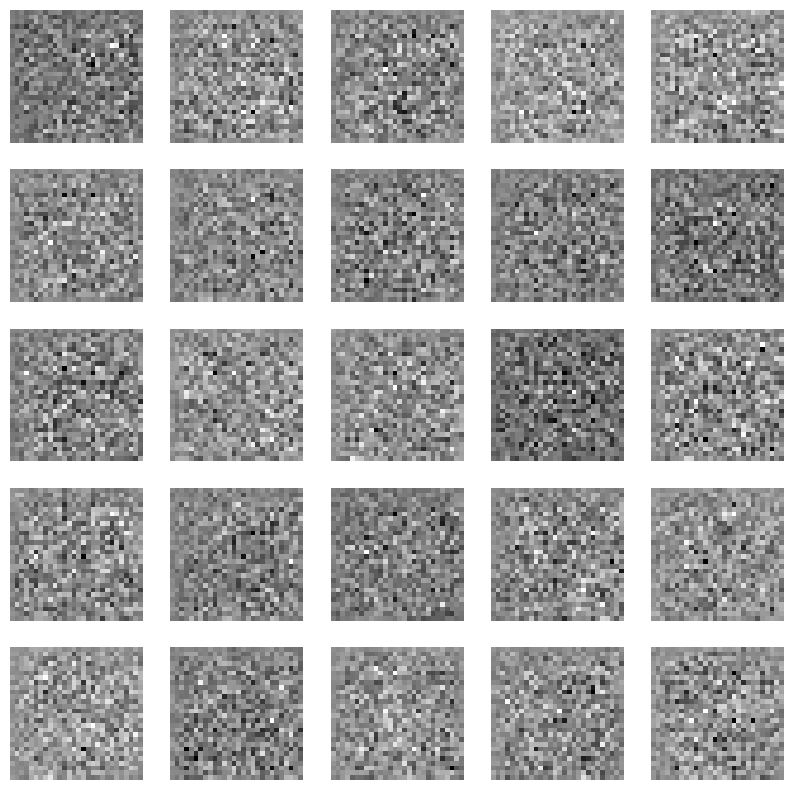

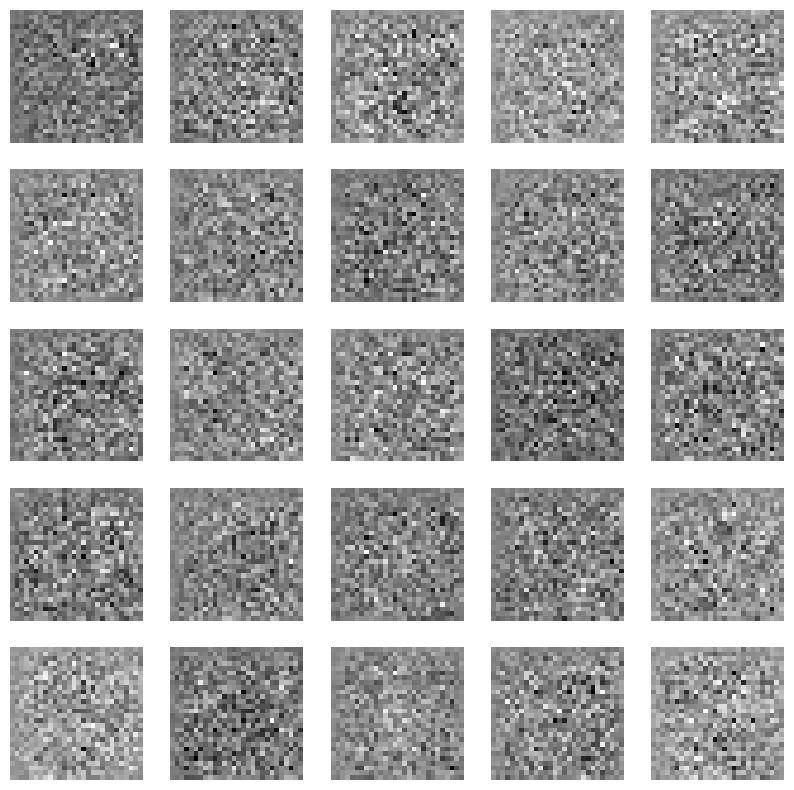

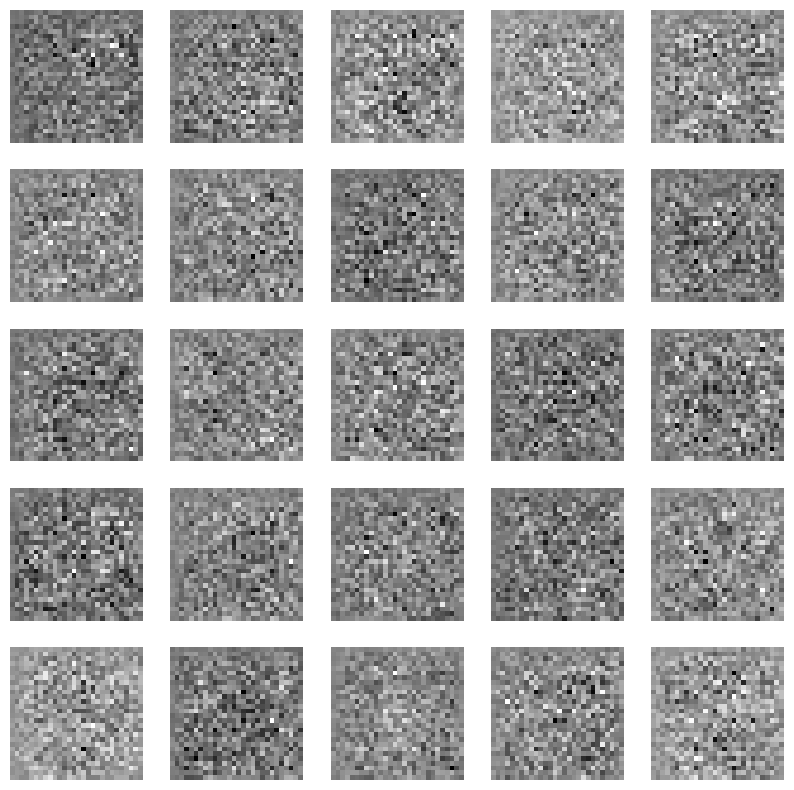

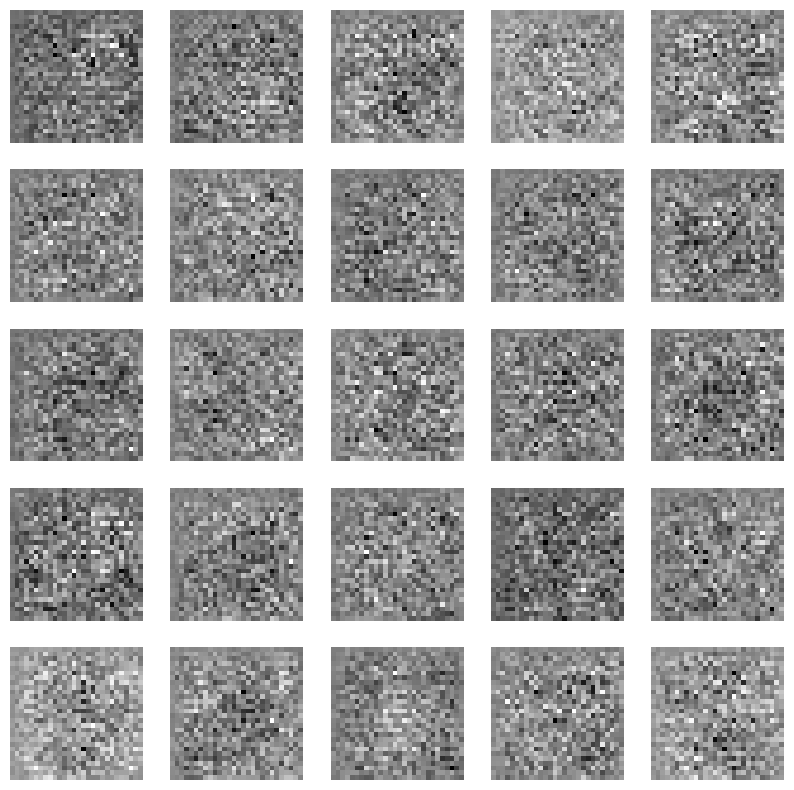

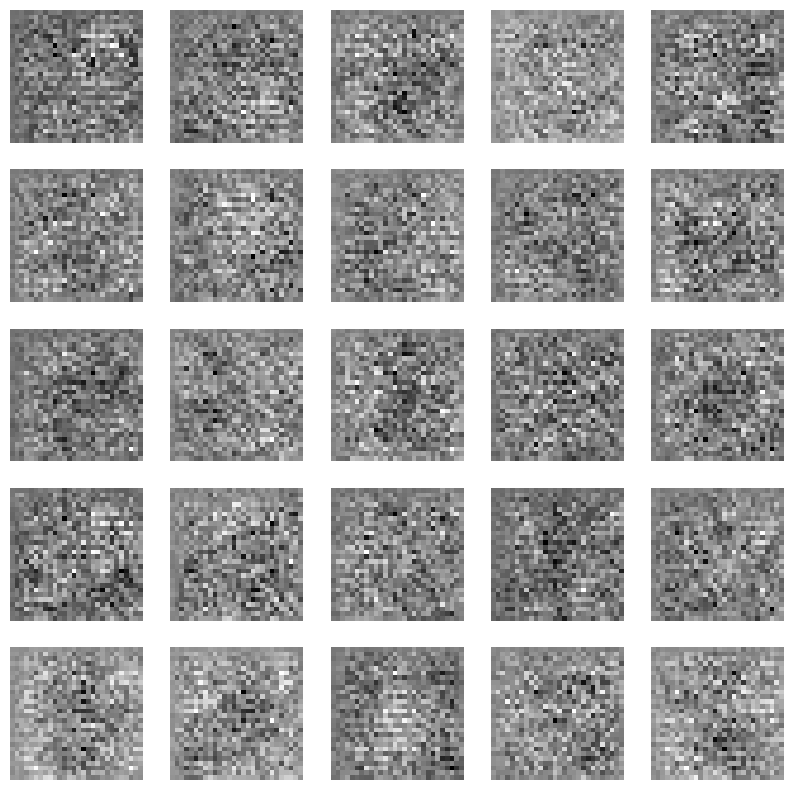

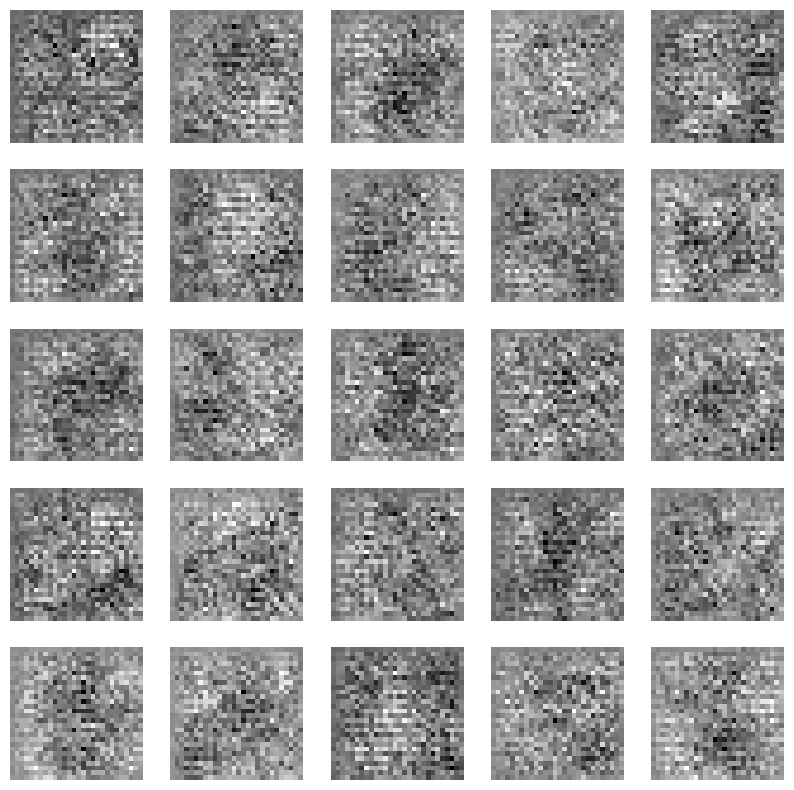

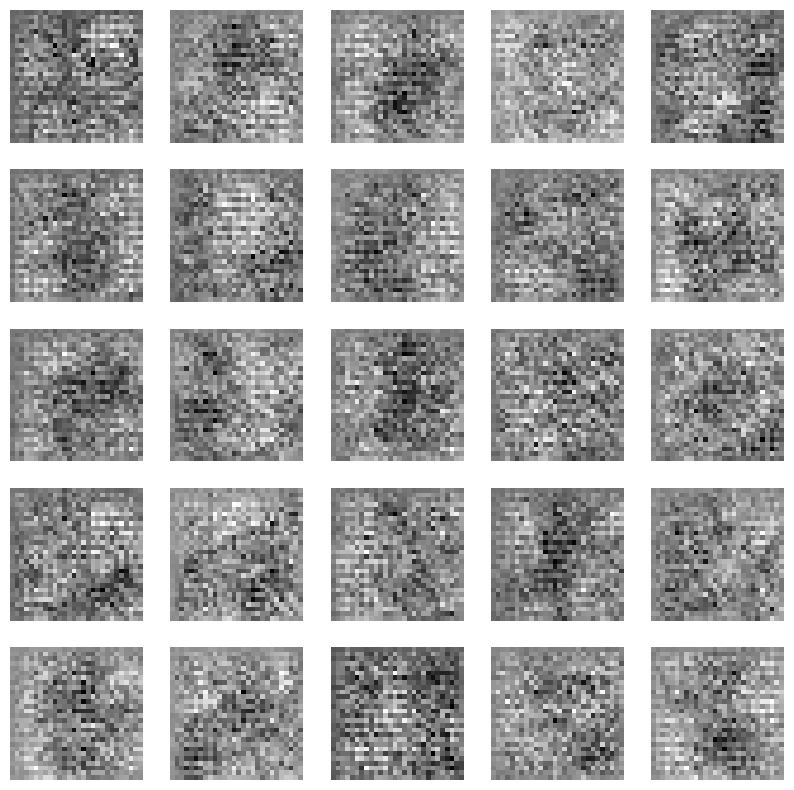

Error in callback <function flush_figures at 0x79cf9ebac160> (for post_execute):


KeyboardInterrupt: 

In [13]:
# code
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize =(10, 10))

  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap ='binary')
    plt.axis('off')

  plt.savefig('image_epoch_{:04d}.png'.format(epoch))

# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 10)


In [1]:
import imageio
import glob

anim_file = 'dcgan_results.gif'

with imageio.get_writer(anim_file, mode ='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
display.Image(filename = anim_file)

<ipython-input-1-1ecd86232368>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-1-1ecd86232368>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


AttributeError: 'function' object has no attribute 'Image'

####**4) Laplacian Pyramid GAN (LAPGAN):**
It uses multiple numbers of generator and discriminator networks at different levels of the Laplacian Pyramid. Laplacian Pyramid GAN (LAPGAN): Utilizes multiple Generators and Discriminators at different levels of a Laplacian Pyramid, creating high-quality images through down-sampling and up-scaling.

- **LAPGAN:** Combines the **CGAN** model with a **Laplacian Pyramid**



Courtesy: https://sh-tsang.medium.com/review-lapgan-laplacian-generative-adversarial-network-gan-e87200bbd827


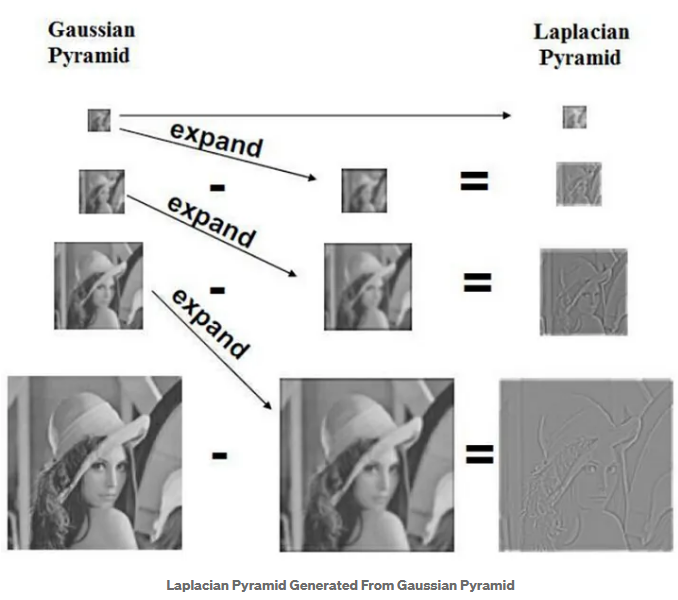

Courtesy: https://github.com/AaronYALai/Generative_Adversarial_Networks_PyTorch/blob/master/LAPGAN/run_LAPGAN.py


In [29]:
# -*- coding: utf-8 -*-
# @Author: aaronlai

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2

from torch.autograd import Variable


class CondiGAN_Discriminator(nn.Module):

    def __init__(self, n_layer=3, condition=True, n_condition=100,
                 use_gpu=False, featmap_dim=256, n_channel=1,
                 condi_featmap_dim=256):
        """
        Conditional Discriminator.
        Architecture brought from DCGAN.
        """
        super(CondiGAN_Discriminator, self).__init__()
        self.n_layer = n_layer
        self.condition = condition

        # original Discriminator
        self.featmap_dim = featmap_dim

        convs = []
        BNs = []
        for layer in range(self.n_layer):
            if layer == (self.n_layer - 1):
                n_conv_in = n_channel
            else:
                n_conv_in = int(featmap_dim / (2**(layer + 1)))
            n_conv_out = int(featmap_dim / (2**layer))

            _conv = nn.Conv2d(n_conv_in, n_conv_out, kernel_size=5,
                              stride=2, padding=2)
            if use_gpu:
                _conv = _conv.cuda()
            convs.append(_conv)

            if layer != (self.n_layer - 1):
                _BN = nn.BatchNorm2d(n_conv_out)
                if use_gpu:
                    _BN = _BN.cuda()
                BNs.append(_BN)

        # extra image information to be conditioned on
        if self.condition:
            self.condi_featmap_dim = condi_featmap_dim
            convs_condi = []
            BNs_condi = []

            for layer in range(self.n_layer):
                if layer == (self.n_layer - 1):
                    n_conv_in = n_channel
                else:
                    n_conv_in = int(condi_featmap_dim / (2**(layer + 1)))
                n_conv_out = int(condi_featmap_dim / (2**layer))

                _conv = nn.Conv2d(n_conv_in, n_conv_out, kernel_size=5,
                                  stride=2, padding=2)
                if use_gpu:
                    _conv = _conv.cuda()
                convs_condi.append(_conv)

                if layer != (self.n_layer - 1):
                    _BN = nn.BatchNorm2d(n_conv_out)
                    if use_gpu:
                        _BN = _BN.cuda()
                    BNs_condi.append(_BN)

            self.fc_c = nn.Linear(condi_featmap_dim * 4 * 4, n_condition)

        # register layer modules
        self.convs = nn.ModuleList(convs)
        self.BNs = nn.ModuleList(BNs)
        if self.condition:
            self.convs_condi = nn.ModuleList(convs_condi)
            self.BNs_condi = nn.ModuleList(BNs_condi)

        # output layer
        n_hidden = featmap_dim * 4 * 4
        if self.condition:
            n_hidden += n_condition
        self.fc = nn.Linear(n_hidden, 1)

    def forward(self, x, condi_x=None):
        """
        Concatenate CNN-processed extra information vector at the last layer
        """
        for layer in range(self.n_layer):
            conv_layer = self.convs[self.n_layer - layer - 1]
            if layer == 0:
                x = F.leaky_relu(conv_layer(x), negative_slope=0.2)
            else:
                BN_layer = self.BNs[self.n_layer - layer - 1]
                x = F.leaky_relu(BN_layer(conv_layer(x)), negative_slope=0.2)
        x = x.view(-1, self.featmap_dim * 4 * 4)

        # calculate and concatenate extra information
        if self.condition:
            for layer in range(self.n_layer):
                _conv = self.convs_condi[self.n_layer - layer - 1]
                if layer == 0:
                    condi_x = F.leaky_relu(_conv(condi_x), negative_slope=0.2)
                else:
                    BN_layer = self.BNs_condi[self.n_layer - layer - 1]
                    condi_x = F.leaky_relu(BN_layer(_conv(condi_x)),
                                           negative_slope=0.2)

            condi_x = condi_x.view(-1, self.condi_featmap_dim * 4 * 4)
            condi_x = self.fc_c(condi_x)
            x = torch.cat((x, condi_x), 1)

        # output layer
        x = F.sigmoid(self.fc(x))

        return x


class CondiGAN_Generator(nn.Module):

    def __init__(self, noise_dim=10, n_layer=3, condition=True,
                 n_condition=100, use_gpu=False, featmap_dim=256, n_channel=1,
                 condi_featmap_dim=256):
        """
        Conditional Generator.
        Architecture brought from DCGAN.
        """
        super(CondiGAN_Generator, self).__init__()
        self.n_layer = n_layer
        self.condition = condition

        # extra image information to be conditioned on
        if self.condition:
            self.condi_featmap_dim = condi_featmap_dim

            convs_condi = []
            BNs_condi = []
            for layer in range(self.n_layer):
                if layer == (self.n_layer - 1):
                    n_conv_in = n_channel
                else:
                    n_conv_in = int(condi_featmap_dim / (2**(layer + 1)))
                n_conv_out = int(condi_featmap_dim / (2**layer))

                _conv = nn.Conv2d(n_conv_in, n_conv_out, kernel_size=5,
                                  stride=2, padding=2)
                if use_gpu:
                    _conv = _conv.cuda()
                convs_condi.append(_conv)

                if layer != (self.n_layer - 1):
                    _BN = nn.BatchNorm2d(n_conv_out)
                    if use_gpu:
                        _BN = _BN.cuda()
                    BNs_condi.append(_BN)

            self.fc_c = nn.Linear(condi_featmap_dim * 4 * 4, n_condition)

        # calculate input dimension
        n_input = noise_dim
        if self.condition:
            n_input += n_condition

        # Generator
        self.featmap_dim = featmap_dim
        self.fc1 = nn.Linear(n_input, int(featmap_dim * 4 * 4))

        convs = []
        BNs = []
        for layer in range(self.n_layer):
            if layer == 0:
                n_conv_out = n_channel
            else:
                n_conv_out = featmap_dim / (2 ** (self.n_layer - layer))
            n_conv_in = featmap_dim / (2 ** (self.n_layer - layer - 1))

            n_width = 5 if layer == (self.n_layer - 1) else 6
            _conv = nn.ConvTranspose2d(n_conv_in, n_conv_out, n_width,
                                       stride=2, padding=2)
            if use_gpu:
                _conv = _conv.cuda()
            convs.append(_conv)

            if layer != 0:
                _BN = nn.BatchNorm2d(n_conv_out)
                if use_gpu:
                    _BN = _BN.cuda()
                BNs.append(_BN)

        # register layer modules
        self.convs = nn.ModuleList(convs)
        self.BNs = nn.ModuleList(BNs)
        if self.condition:
            self.convs_condi = nn.ModuleList(convs_condi)
            self.BNs_condi = nn.ModuleList(BNs_condi)

    def forward(self, x, condi_x=None):
        """
        Concatenate CNN-processed extra information vector at the first layer
        """
        # calculate and concatenate extra information
        if self.condition:
            for layer in range(self.n_layer):
                _conv = self.convs_condi[self.n_layer - layer - 1]
                if layer == 0:
                    condi_x = F.leaky_relu(_conv(condi_x), negative_slope=0.2)
                else:
                    BN_layer = self.BNs_condi[self.n_layer - layer - 1]
                    condi_x = F.leaky_relu(BN_layer(_conv(condi_x)),
                                           negative_slope=0.2)

            condi_x = condi_x.view(-1, self.condi_featmap_dim * 4 * 4)
            condi_x = self.fc_c(condi_x)
            x = torch.cat((x, condi_x), 1)

        x = self.fc1(x)
        x = x.view(-1, self.featmap_dim, 4, 4)

        for layer in range(self.n_layer):
            conv_layer = self.convs[self.n_layer - layer - 1]
            if layer == (self.n_layer - 1):
                x = F.tanh(conv_layer(x))
            else:
                BN_layer = self.BNs[self.n_layer - layer - 2]
                x = F.relu(BN_layer(conv_layer(x)))

        return x


class LAPGAN(object):

    def __init__(self, n_level, noise_dim=10, n_condition=100,
                 D_featmap_dim=64, condi_D_featmap_dim=64,
                 G_featmap_dim=256, condi_G_featmap_dim=64,
                 use_gpu=False, n_channel=1):
        """
        Initialize a group of discriminators and generators for LAPGAN
        n_level: number of levels in the Laplacian Pyramid
        noise_dim: dimension of random noise to feed into the last generator
        D_featmap_dim: discriminator, (#feature maps) in the last layer of CNN
        condi_D_featmap_dim: (#feature maps) of extra info CNN's last layer
        G_featmap_dim: generator, (#feature maps) of deconvNN's first layer
        condi_G_featmap_dim: (#feature maps) of extra info CNN's last layer
        use_gpu: to use GPU computation or not
        n_channel: number of channel for input images
        """
        self.n_level = n_level
        self.n_channel = n_channel
        self.use_gpu = use_gpu
        self.noise_dim = noise_dim
        self.Dis_models = []
        self.Gen_models = []

        for level in range(n_level):
            n_layer = n_level - level
            if level == (n_level - 1):
                condition = False
            else:
                condition = True

            Dis_model = CondiGAN_Discriminator(n_layer, condition, n_condition,
                                               use_gpu, D_featmap_dim,
                                               n_channel, condi_D_featmap_dim)
            Gen_model = CondiGAN_Generator(noise_dim, n_layer, condition,
                                           n_condition, use_gpu, G_featmap_dim,
                                           n_channel, condi_G_featmap_dim)

            if use_gpu:
                Dis_model = Dis_model.cuda()
                Gen_model = Gen_model.cuda()

            self.Dis_models.append(Dis_model)
            self.Gen_models.append(Gen_model)

    def generate(self, batchsize, get_level=None, generator=False):
        """Generate images from LAPGAN generators"""
        self.outputs = []
        self.generator_outputs = []
        for level in range(self.n_level):
            Gen_model = self.Gen_models[self.n_level - level - 1]

            # generate noise
            noise = Variable(gen_noise(batchsize, self.noise_dim))
            if self.use_gpu:
                noise = noise.cuda()

            if level == 0:
                # directly generate images
                output_imgs = Gen_model.forward(noise)
                if self.use_gpu:
                    output_imgs = output_imgs.cpu()
                output_imgs = output_imgs.data.numpy()
                self.generator_outputs.append(output_imgs)
            else:
                # upsize
                input_imgs = np.array([[cv2.pyrUp(output_imgs[i, j, :])
                                      for j in range(self.n_channel)]
                                      for i in range(batchsize)])
                condi_imgs = Variable(torch.Tensor(input_imgs))
                if self.use_gpu:
                    condi_imgs = condi_imgs.cuda()

                # generate images with extra information
                residual_imgs = Gen_model.forward(noise, condi_imgs)
                if self.use_gpu:
                    residual_imgs = residual_imgs.cpu()
                output_imgs = residual_imgs.data.numpy() + input_imgs
                self.generator_outputs.append(residual_imgs.data.numpy())

            self.outputs.append(output_imgs)

        if get_level is None:
            get_level = -1

        if generator:
            result_imgs = self.generator_outputs[get_level]
        else:
            result_imgs = self.outputs[get_level]

        return result_imgs


def gen_noise(n_instance, n_dim=2):
    """generate n-dim uniform random noise"""
    return torch.Tensor(np.random.uniform(low=-1.0, high=1.0,
                                          size=(n_instance, n_dim)))

In [30]:
# -*- coding: utf-8 -*-
# @Author: aaronlai

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2

from torch.autograd import Variable
from LAPGAN import LAPGAN, gen_noise


def load_dataset(batch_size=10, download=True):
    """
    The output of torchvision datasets are PILImage images of range [0, 1].
    Transform them to Tensors of normalized range [-1, 1]
    """
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                          download=download,
                                          transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(root='../data', train=False,
                                         download=download,
                                         transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

    return trainloader, testloader


def train_LAPGAN(LapGan_model, n_level, D_criterions, G_criterions,
                 D_optimizers, G_optimizers, trainloader, n_epoch,
                 batch_size, noise_dim, n_update_dis=1, n_update_gen=1,
                 use_gpu=False, print_every=10, update_max=None):
    """train LAPGAN and print out the losses for Ds and Gs"""
    for epoch in range(n_epoch):

        D_running_losses = [0.0 for i in range(n_level)]
        G_running_losses = [0.0 for i in range(n_level)]

        for ind, data in enumerate(trainloader, 0):
            # get the inputs from true distribution
            true_inputs, lab = data
            down_imgs = true_inputs.numpy()
            n_minibatch, n_channel, _, _ = down_imgs.shape

            for l in range(n_level):
                # calculate input images for models at the particular level
                if l == (n_level - 1):
                    condi_inputs = None
                    true_inputs = Variable(torch.Tensor(down_imgs))
                    if use_gpu:
                        true_inputs = true_inputs.cuda()
                else:
                    new_down_imgs = []
                    up_imgs = []
                    residual_imgs = []

                    # compute a Laplacian Pyramid
                    for i in range(n_minibatch):
                        down_img = []
                        up_img = []
                        residual_img = []

                        for j in range(n_channel):
                            previous = down_imgs[i, j, :]
                            down_img.append(cv2.pyrDown(previous))
                            up_img.append(cv2.pyrUp(down_img[-1]))
                            residual_img.append(previous - up_img[-1])

                        new_down_imgs.append(down_img)
                        up_imgs.append(up_img)
                        residual_imgs.append(residual_img)

                    down_imgs = np.array(new_down_imgs)
                    up_imgs = np.array(up_imgs)
                    residual_imgs = np.array(residual_imgs)

                    condi_inputs = Variable(torch.Tensor(up_imgs))
                    true_inputs = Variable(torch.Tensor(residual_imgs))
                    if use_gpu:
                        condi_inputs = condi_inputs.cuda()
                        true_inputs = true_inputs.cuda()

                # get inputs for discriminators from generators and real data
                noise = Variable(gen_noise(batch_size, noise_dim))
                if use_gpu:
                    noise = noise.cuda()
                fake_inputs = LapGan_model.Gen_models[l](noise, condi_inputs)
                inputs = torch.cat([true_inputs, fake_inputs])
                labels = np.zeros(2 * batch_size)
                labels[:batch_size] = 1
                labels = Variable(torch.from_numpy(labels.astype(np.float32)))
                if use_gpu:
                    labels = labels.cuda()

                # Discriminator
                D_optimizers[l].zero_grad()
                if condi_inputs:
                    condi_inputs = torch.cat((condi_inputs, condi_inputs))
                outputs = LapGan_model.Dis_models[l](inputs, condi_inputs)
                D_loss = D_criterions[l](outputs[:, 0], labels)

                if ind % n_update_dis == 0:
                    D_loss.backward(retain_variables=True)
                    D_optimizers[l].step()

                # Generator
                if ind % n_update_gen == 0:
                    G_optimizers[l].zero_grad()
                    G_loss = G_criterions[l](outputs[batch_size:, 0],
                                             labels[:batch_size])
                    G_loss.backward()
                    G_optimizers[l].step()

                # print statistics
                D_running_losses[l] += D_loss.data[0]
                G_running_losses[l] += G_loss.data[0]
                if ind % print_every == (print_every - 1):
                    print('[%d, %5d, %d] D loss: %.3f ; G loss: %.3f' %
                          (epoch+1, ind+1, l+1,
                           D_running_losses[l] / print_every,
                           G_running_losses[l] / print_every))
                    D_running_losses[l] = 0.0
                    G_running_losses[l] = 0.0

            if update_max and ind > update_max:
                break

    print('Finished Training')


def run_LAPGAN(n_level=3, n_epoch=2, batch_size=20, use_gpu=False,
               dis_lrs=None, gen_lrs=None, n_update_dis=1, n_update_gen=1,
               noise_dim=10, n_condition=100, D_featmap_dim=128,
               condi_D_featmap_dim=128, G_featmap_dim=256,
               condi_G_featmap_dim=128, n_channel=1, n_sample=25,
               update_max=None):
    # loading data
    trainloader, testloader = load_dataset(batch_size=batch_size)

    # initialize models
    LapGan_model = LAPGAN(n_level, noise_dim, n_condition, D_featmap_dim,
                          condi_D_featmap_dim, G_featmap_dim,
                          condi_G_featmap_dim, use_gpu, n_channel)

    # assign loss function and optimizer (Adam) to D and G
    D_criterions = []
    G_criterions = []

    D_optimizers = []
    G_optimizers = []

    if not dis_lrs:
        dis_lrs = [0.0002, 0.0003, 0.001]

    if not gen_lrs:
        gen_lrs = [0.001, 0.005, 0.01]

    for l in range(n_level):
        D_criterions.append(nn.BCELoss())
        D_optim = optim.Adam(LapGan_model.Dis_models[l].parameters(),
                             lr=dis_lrs[l], betas=(0.5, 0.999))
        D_optimizers.append(D_optim)

        G_criterions.append(nn.BCELoss())
        G_optim = optim.Adam(LapGan_model.Gen_models[l].parameters(),
                             lr=gen_lrs[l], betas=(0.5, 0.999))
        G_optimizers.append(G_optim)

    train_LAPGAN(LapGan_model, n_level, D_criterions, G_criterions,
                 D_optimizers, G_optimizers, trainloader, n_epoch,
                 batch_size, noise_dim, n_update_dis, n_update_gen,
                 update_max=update_max)

    return LapGan_model.generate(n_sample)


if __name__ == '__main__':
    run_LAPGAN(n_epoch=1, D_featmap_dim=64, condi_D_featmap_dim=64,
               G_featmap_dim=128, condi_G_featmap_dim=64, update_max=50)

ModuleNotFoundError: No module named 'LAPGAN'

Courtesy: https://www.tensorflow.org/hub/tutorials/image_enhancing

####**5) Super Resolution GAN (SRGAN):**
Super Resolution GAN (SRGAN): A GAN designed for up-scaling low-resolution images using a deep neural network, enhancing image details with minimal errors


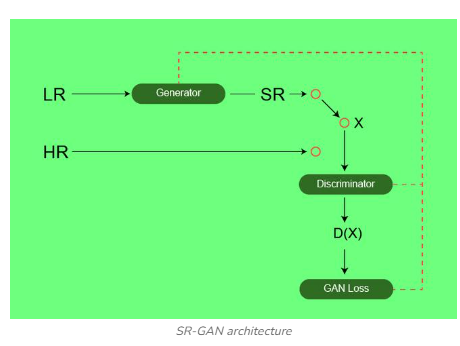


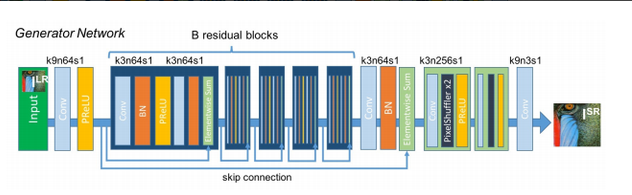

In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [4]:
# wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

In [10]:
# Declaring Constants
IMAGE_PATH = "Picture1.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [11]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [12]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [13]:
hr_image = preprocess_image(IMAGE_PATH)

In [14]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

Saved as Original Image.jpg


In [15]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [16]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 212.545883


Saved as Super Resolution.jpg


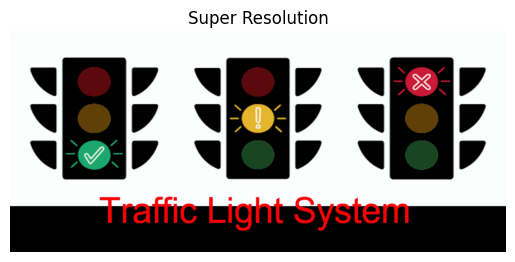

In [17]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [18]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

--2024-10-05 17:46:23--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 173.194.210.132, 2607:f8b0:400c:c0f::84
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|173.194.210.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84915 (83K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  82.92K  --.-KB/s    in 0.001s  

2024-10-05 17:46:23 (77.7 MB/s) - ‘test.jpg’ saved [84915/84915]



In [19]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [20]:
hr_image = preprocess_image(IMAGE_PATH)

In [21]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [22]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [23]:
model = hub.load(SAVED_MODEL_PATH)

In [24]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 6.083594


In [25]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR Achieved: 28.029171


In [26]:
#Comparing Output size by side
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

PSNR: 28.029171


####**6) SeqGAN (for sequential data, i.e., NLP):**
SeqGAN is a GAN designed for sequence generation, such as text or time series, using reinforcement learning to handle discrete data. The Discriminator evaluates entire sequences to distinguish real from generated ones

Courtesy: https://github.com/LantaoYu/SeqGAN



image.png

Courtesy: https://github.com/LantaoYu/SeqGAN/blob/master/dataloader.py

In [81]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [82]:
#i) DataLoader

import numpy as np


class Gen_Data_loader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.token_stream = []

    def create_batches(self, data_file):
        self.token_stream = []
        with open(data_file, 'r') as f:
            for line in f:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                if len(parse_line) == 20:
                    self.token_stream.append(parse_line)

        self.num_batch = int(len(self.token_stream) / self.batch_size)
        self.token_stream = self.token_stream[:self.num_batch * self.batch_size]
        self.sequence_batch = np.split(np.array(self.token_stream), self.num_batch, 0)
        self.pointer = 0

    def next_batch(self):
        ret = self.sequence_batch[self.pointer]
        self.pointer = (self.pointer + 1) % self.num_batch
        return ret

    def reset_pointer(self):
        self.pointer = 0


class Dis_dataloader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.sentences = np.array([])
        self.labels = np.array([])

    def load_train_data(self, positive_file, negative_file):
        # Load data
        positive_examples = []
        negative_examples = []
        with open(positive_file)as fin:
            for line in fin:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                positive_examples.append(parse_line)
        with open(negative_file)as fin:
            for line in fin:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                if len(parse_line) == 20:
                    negative_examples.append(parse_line)
        self.sentences = np.array(positive_examples + negative_examples)

        # Generate labels
        positive_labels = [[0, 1] for _ in positive_examples]
        negative_labels = [[1, 0] for _ in negative_examples]
        self.labels = np.concatenate([positive_labels, negative_labels], 0)

        # Shuffle the data
        shuffle_indices = np.random.permutation(np.arange(len(self.labels)))
        self.sentences = self.sentences[shuffle_indices]
        self.labels = self.labels[shuffle_indices]

        # Split batches
        self.num_batch = int(len(self.labels) / self.batch_size)
        self.sentences = self.sentences[:self.num_batch * self.batch_size]
        self.labels = self.labels[:self.num_batch * self.batch_size]
        self.sentences_batches = np.split(self.sentences, self.num_batch, 0)
        self.labels_batches = np.split(self.labels, self.num_batch, 0)

        self.pointer = 0


    def next_batch(self):
        ret = self.sentences_batches[self.pointer], self.labels_batches[self.pointer]
        self.pointer = (self.pointer + 1) % self.num_batch
        return ret

    def reset_pointer(self):
        self.pointer = 0

In [60]:
#ii) Discriminator

import tensorflow as tf
import numpy as np

# An alternative to tf.nn.rnn_cell._linear function, which has been removed in Tensorfow 1.0.1
# The highway layer is borrowed from https://github.com/mkroutikov/tf-lstm-char-cnn
def linear(input_, output_size, scope=None):
    '''
    Linear map: output[k] = sum_i(Matrix[k, i] * input_[i] ) + Bias[k]
    Args:
    input_: a tensor or a list of 2D, batch x n, Tensors.
    output_size: int, second dimension of W[i].
    scope: VariableScope for the created subgraph; defaults to "Linear".
  Returns:
    A 2D Tensor with shape [batch x output_size] equal to
    sum_i(input_[i] * W[i]), where W[i]s are newly created matrices.
  Raises:
    ValueError: if some of the arguments has unspecified or wrong shape.
  '''

    shape = input_.get_shape().as_list()
    if len(shape) != 2:
        raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
    if not shape[1]:
        raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
    input_size = shape[1]

    # Now the computation.
    with tf.variable_scope(scope or "SimpleLinear"):
        matrix = tf.get_variable("Matrix", [output_size, input_size], dtype=input_.dtype)
        bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

    return tf.matmul(input_, tf.transpose(matrix)) + bias_term

def highway(input_, size, num_layers=1, bias=-2.0, f=tf.nn.relu, scope='Highway'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """

    with tf.variable_scope(scope):
        for idx in range(num_layers):
            g = f(linear(input_, size, scope='highway_lin_%d' % idx))

            t = tf.sigmoid(linear(input_, size, scope='highway_gate_%d' % idx) + bias)

            output = t * g + (1. - t) * input_
            input_ = output

    return output

class Discriminator(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """

    def __init__(
            self, sequence_length, num_classes, vocab_size,
            embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        with tf.variable_scope('discriminator'):

            # Embedding layer
            with tf.device('/cpu:0'), tf.name_scope("embedding"):
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
                self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
                self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

            # Create a convolution + maxpool layer for each filter size
            pooled_outputs = []
            for filter_size, num_filter in zip(filter_sizes, num_filters):
                with tf.name_scope("conv-maxpool-%s" % filter_size):
                    # Convolution Layer
                    filter_shape = [filter_size, embedding_size, 1, num_filter]
                    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                    b = tf.Variable(tf.constant(0.1, shape=[num_filter]), name="b")
                    conv = tf.nn.conv2d(
                        self.embedded_chars_expanded,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
                    # Apply nonlinearity
                    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                    # Maxpooling over the outputs
                    pooled = tf.nn.max_pool(
                        h,
                        ksize=[1, sequence_length - filter_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
                    pooled_outputs.append(pooled)

            # Combine all the pooled features
            num_filters_total = sum(num_filters)
            self.h_pool = tf.concat(pooled_outputs, 3)
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

            # Add highway
            with tf.name_scope("highway"):
                self.h_highway = highway(self.h_pool_flat, self.h_pool_flat.get_shape()[1], 1, 0)

            # Add dropout
            with tf.name_scope("dropout"):
                self.h_drop = tf.nn.dropout(self.h_highway, self.dropout_keep_prob)

            # Final (unnormalized) scores and predictions
            with tf.name_scope("output"):
                W = tf.Variable(tf.truncated_normal([num_filters_total, num_classes], stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
                self.ypred_for_auc = tf.nn.softmax(self.scores)
                self.predictions = tf.argmax(self.scores, 1, name="predictions")

            # CalculateMean cross-entropy loss
            with tf.name_scope("loss"):
                losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
                self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        self.params = [param for param in tf.trainable_variables() if 'discriminator' in param.name]
        d_optimizer = tf.train.AdamOptimizer(1e-4)
        grads_and_vars = d_optimizer.compute_gradients(self.loss, self.params, aggregation_method=2)
        self.train_op = d_optimizer.apply_gradients(grads_and_vars)

In [62]:
#iii) Generator

import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops


class Generator(object):
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim,
                 sequence_length, start_token,
                 learning_rate=0.01, reward_gamma=0.95):
        self.num_emb = num_emb
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = tf.constant([start_token] * self.batch_size, dtype=tf.int32)
        self.learning_rate = tf.Variable(float(learning_rate), trainable=False)
        self.reward_gamma = reward_gamma
        self.g_params = []
        self.d_params = []
        self.temperature = 1.0
        self.grad_clip = 5.0

        self.expected_reward = tf.Variable(tf.zeros([self.sequence_length]))

        with tf.variable_scope('generator'):
            self.g_embeddings = tf.Variable(self.init_matrix([self.num_emb, self.emb_dim]))
            self.g_params.append(self.g_embeddings)
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.rewards = tf.placeholder(tf.float32, shape=[self.batch_size, self.sequence_length]) # get from rollout policy and discriminator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # Initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, gen_o, gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
            )
        ) / (self.sequence_length * self.batch_size)

        # training updates
        pretrain_opt = self.g_optimizer(self.learning_rate)

        self.pretrain_grad, _ = tf.clip_by_global_norm(tf.gradients(self.pretrain_loss, self.g_params), self.grad_clip)
        self.pretrain_updates = pretrain_opt.apply_gradients(zip(self.pretrain_grad, self.g_params))

        #######################################################################################################
        #  Unsupervised Training
        #######################################################################################################
        self.g_loss = -tf.reduce_sum(
            tf.reduce_sum(
                tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                    tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
                ), 1) * tf.reshape(self.rewards, [-1])
        )

        g_opt = self.g_optimizer(self.learning_rate)

        self.g_grad, _ = tf.clip_by_global_norm(tf.gradients(self.g_loss, self.g_params), self.grad_clip)
        self.g_updates = g_opt.apply_gradients(zip(self.g_grad, self.g_params))

    def generate(self, sess):
        outputs = sess.run(self.gen_x)
        return outputs

    def pretrain_step(self, sess, x):
        outputs = sess.run([self.pretrain_updates, self.pretrain_loss], feed_dict={self.x: x})
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

    def init_vector(self, shape):
        return tf.zeros(shape)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wf = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wog = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uog = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bog = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wc = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_dim]))
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.init_matrix([self.hidden_dim, self.num_emb]))
        self.bo = tf.Variable(self.init_matrix([self.num_emb]))
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def g_optimizer(self, *args, **kwargs):
        return tf.train.AdamOptimizer(*args, **kwargs)

In [63]:
#iv) Roll-Out

import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import numpy as np


class ROLLOUT(object):
    def __init__(self, lstm, update_rate):
        self.lstm = lstm
        self.update_rate = update_rate

        self.num_emb = self.lstm.num_emb
        self.batch_size = self.lstm.batch_size
        self.emb_dim = self.lstm.emb_dim
        self.hidden_dim = self.lstm.hidden_dim
        self.sequence_length = self.lstm.sequence_length
        self.start_token = tf.identity(self.lstm.start_token)
        self.learning_rate = self.lstm.learning_rate

        self.g_embeddings = tf.identity(self.lstm.g_embeddings)
        self.g_recurrent_unit = self.create_recurrent_unit()  # maps h_tm1 to h_t for generator
        self.g_output_unit = self.create_output_unit()  # maps h_t to o_t (output token logits)

        #####################################################################################################
        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.given_num = tf.placeholder(tf.int32)

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        ta_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length)
        ta_x = ta_x.unstack(tf.transpose(self.x, perm=[1, 0]))
        #####################################################################################################

        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        # When current index i < given_num, use the provided tokens as the input at each time step
        def _g_recurrence_1(i, x_t, h_tm1, given_num, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            x_tp1 = ta_emb_x.read(i)
            gen_x = gen_x.write(i, ta_x.read(i))
            return i + 1, x_tp1, h_t, given_num, gen_x

        # When current index i >= given_num, start roll-out, use the output as time step t as the input at time step t+1
        def _g_recurrence_2(i, x_t, h_tm1, given_num, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, given_num, gen_x

        i, x_t, h_tm1, given_num, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, given_num, _4: i < given_num,
            body=_g_recurrence_1,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, self.given_num, gen_x))

        _, _, _, _, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence_2,
            loop_vars=(i, x_t, h_tm1, given_num, self.gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

    def get_reward(self, sess, input_x, rollout_num, discriminator):
        rewards = []
        for i in range(rollout_num):
            # given_num between 1 to sequence_length - 1 for a part completed sentence
            for given_num in range(1, self.sequence_length ):
                feed = {self.x: input_x, self.given_num: given_num}
                samples = sess.run(self.gen_x, feed)
                feed = {discriminator.input_x: samples, discriminator.dropout_keep_prob: 1.0}
                ypred_for_auc = sess.run(discriminator.ypred_for_auc, feed)
                ypred = np.array([item[1] for item in ypred_for_auc])
                if i == 0:
                    rewards.append(ypred)
                else:
                    rewards[given_num - 1] += ypred

            # the last token reward
            feed = {discriminator.input_x: input_x, discriminator.dropout_keep_prob: 1.0}
            ypred_for_auc = sess.run(discriminator.ypred_for_auc, feed)
            ypred = np.array([item[1] for item in ypred_for_auc])
            if i == 0:
                rewards.append(ypred)
            else:
                # completed sentence reward
                rewards[self.sequence_length - 1] += ypred

        rewards = np.transpose(np.array(rewards)) / (1.0 * rollout_num)  # batch_size x seq_length
        return rewards

    def create_recurrent_unit(self):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.identity(self.lstm.Wi)
        self.Ui = tf.identity(self.lstm.Ui)
        self.bi = tf.identity(self.lstm.bi)

        self.Wf = tf.identity(self.lstm.Wf)
        self.Uf = tf.identity(self.lstm.Uf)
        self.bf = tf.identity(self.lstm.bf)

        self.Wog = tf.identity(self.lstm.Wog)
        self.Uog = tf.identity(self.lstm.Uog)
        self.bog = tf.identity(self.lstm.bog)

        self.Wc = tf.identity(self.lstm.Wc)
        self.Uc = tf.identity(self.lstm.Uc)
        self.bc = tf.identity(self.lstm.bc)

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def update_recurrent_unit(self):
        # Weights and Bias for input and hidden tensor
        self.Wi = self.update_rate * self.Wi + (1 - self.update_rate) * tf.identity(self.lstm.Wi)
        self.Ui = self.update_rate * self.Ui + (1 - self.update_rate) * tf.identity(self.lstm.Ui)
        self.bi = self.update_rate * self.bi + (1 - self.update_rate) * tf.identity(self.lstm.bi)

        self.Wf = self.update_rate * self.Wf + (1 - self.update_rate) * tf.identity(self.lstm.Wf)
        self.Uf = self.update_rate * self.Uf + (1 - self.update_rate) * tf.identity(self.lstm.Uf)
        self.bf = self.update_rate * self.bf + (1 - self.update_rate) * tf.identity(self.lstm.bf)

        self.Wog = self.update_rate * self.Wog + (1 - self.update_rate) * tf.identity(self.lstm.Wog)
        self.Uog = self.update_rate * self.Uog + (1 - self.update_rate) * tf.identity(self.lstm.Uog)
        self.bog = self.update_rate * self.bog + (1 - self.update_rate) * tf.identity(self.lstm.bog)

        self.Wc = self.update_rate * self.Wc + (1 - self.update_rate) * tf.identity(self.lstm.Wc)
        self.Uc = self.update_rate * self.Uc + (1 - self.update_rate) * tf.identity(self.lstm.Uc)
        self.bc = self.update_rate * self.bc + (1 - self.update_rate) * tf.identity(self.lstm.bc)

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self):
        self.Wo = tf.identity(self.lstm.Wo)
        self.bo = tf.identity(self.lstm.bo)

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def update_output_unit(self):
        self.Wo = self.update_rate * self.Wo + (1 - self.update_rate) * tf.identity(self.lstm.Wo)
        self.bo = self.update_rate * self.bo + (1 - self.update_rate) * tf.identity(self.lstm.bo)

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def update_params(self):
        self.g_embeddings = tf.identity(self.lstm.g_embeddings)
        self.g_recurrent_unit = self.update_recurrent_unit()
        self.g_output_unit = self.update_output_unit()

In [65]:
#v) Target LSTM

import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops


class TARGET_LSTM(object):
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim, sequence_length, start_token, params):
        self.num_emb = num_emb
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = tf.constant([start_token] * self.batch_size, dtype=tf.int32)
        self.g_params = []
        self.temperature = 1.0
        self.params = params

        tf.set_random_seed(66)

        with tf.variable_scope('generator'):
            self.g_embeddings = tf.Variable(self.params[0])
            self.g_params.append(self.g_embeddings)
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        # generator on initial randomness
        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, gen_o, gen_x)
            )

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(
            self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.reshape(self.g_predictions, [-1, self.num_emb]))) / (self.sequence_length * self.batch_size)

        self.out_loss = tf.reduce_sum(
            tf.reshape(
                -tf.reduce_sum(
                    tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                        tf.reshape(self.g_predictions, [-1, self.num_emb])), 1
                ), [-1, self.sequence_length]
            ), 1
        )  # batch_size

    def generate(self, session):
        # h0 = np.random.normal(size=self.hidden_dim)
        outputs = session.run(self.gen_x)
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=1.0)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.params[1])
        self.Ui = tf.Variable(self.params[2])
        self.bi = tf.Variable(self.params[3])

        self.Wf = tf.Variable(self.params[4])
        self.Uf = tf.Variable(self.params[5])
        self.bf = tf.Variable(self.params[6])

        self.Wog = tf.Variable(self.params[7])
        self.Uog = tf.Variable(self.params[8])
        self.bog = tf.Variable(self.params[9])

        self.Wc = tf.Variable(self.params[10])
        self.Uc = tf.Variable(self.params[11])
        self.bc = tf.Variable(self.params[12])
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.params[13])
        self.bo = tf.Variable(self.params[14])
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

In [84]:
#i) DataLoader

import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # disable v2 behaviour to get back to the state of v1


from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Use this:
from tensorflow.python.ops import tensor_array_ops


class Gen_Data_loader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.token_stream = []

    def create_batches(self, data_file):
        self.token_stream = []
        with open(data_file, 'r') as f:
            for line in f:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                if len(parse_line) == 20:
                    self.token_stream.append(parse_line)

        self.num_batch = int(len(self.token_stream) / self.batch_size)
        self.token_stream = self.token_stream[:self.num_batch * self.batch_size]
        self.sequence_batch = np.split(np.array(self.token_stream), self.num_batch, 0)
        self.pointer = 0

    def next_batch(self):
        ret = self.sequence_batch[self.pointer]
        self.pointer = (self.pointer + 1) % self.num_batch
        return ret

    def reset_pointer(self):
        self.pointer = 0


class Dis_dataloader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.sentences = np.array([])
        self.labels = np.array([])

    def load_train_data(self, positive_file, negative_file):
        # Load data
        positive_examples = []
        negative_examples = []
        with open(positive_file)as fin:
            for line in fin:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                positive_examples.append(parse_line)
        with open(negative_file)as fin:
            for line in fin:
                line = line.strip()
                line = line.split()
                parse_line = [int(x) for x in line]
                if len(parse_line) == 20:
                    negative_examples.append(parse_line)
        self.sentences = np.array(positive_examples + negative_examples)

        # Generate labels
        positive_labels = [[0, 1] for _ in positive_examples]
        negative_labels = [[1, 0] for _ in negative_examples]
        self.labels = np.concatenate([positive_labels, negative_labels], 0)

        # Shuffle the data
        shuffle_indices = np.random.permutation(np.arange(len(self.labels)))
        self.sentences = self.sentences[shuffle_indices]
        self.labels = self.labels[shuffle_indices]

        # Split batches
        self.num_batch = int(len(self.labels) / self.batch_size)
        self.sentences = self.sentences[:self.num_batch * self.batch_size]
        self.labels = self.labels[:self.num_batch * self.batch_size]
        self.sentences_batches = np.split(self.sentences, self.num_batch, 0)
        self.labels_batches = np.split(self.labels, self.num_batch, 0)

        self.pointer = 0


    def next_batch(self):
        ret = self.sentences_batches[self.pointer], self.labels_batches[self.pointer]
        self.pointer = (self.pointer + 1) % self.num_batch
        return ret

    def reset_pointer(self):
        self.pointer = 0


#ii) Discriminator

import tensorflow as tf
import numpy as np

# An alternative to tf.nn.rnn_cell._linear function, which has been removed in Tensorfow 1.0.1
# The highway layer is borrowed from https://github.com/mkroutikov/tf-lstm-char-cnn
def linear(input_, output_size, scope=None):
    '''
    Linear map: output[k] = sum_i(Matrix[k, i] * input_[i] ) + Bias[k]
    Args:
    input_: a tensor or a list of 2D, batch x n, Tensors.
    output_size: int, second dimension of W[i].
    scope: VariableScope for the created subgraph; defaults to "Linear".
  Returns:
    A 2D Tensor with shape [batch x output_size] equal to
    sum_i(input_[i] * W[i]), where W[i]s are newly created matrices.
  Raises:
    ValueError: if some of the arguments has unspecified or wrong shape.
  '''

    shape = input_.get_shape().as_list()
    if len(shape) != 2:
        raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
    if not shape[1]:
        raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
    input_size = shape[1]

    # Now the computation.
    with tf.variable_scope(scope or "SimpleLinear"):
        matrix = tf.get_variable("Matrix", [output_size, input_size], dtype=input_.dtype)
        bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

    return tf.matmul(input_, tf.transpose(matrix)) + bias_term

def highway(input_, size, num_layers=1, bias=-2.0, f=tf.nn.relu, scope='Highway'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """

    with tf.variable_scope(scope):
        for idx in range(num_layers):
            g = f(linear(input_, size, scope='highway_lin_%d' % idx))

            t = tf.sigmoid(linear(input_, size, scope='highway_gate_%d' % idx) + bias)

            output = t * g + (1. - t) * input_
            input_ = output

    return output

class Discriminator(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """

    def __init__(
            self, sequence_length, num_classes, vocab_size,
            embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        with tf.variable_scope('discriminator'):

            # Embedding layer
            with tf.device('/cpu:0'), tf.name_scope("embedding"):
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
                self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
                self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

            # Create a convolution + maxpool layer for each filter size
            pooled_outputs = []
            for filter_size, num_filter in zip(filter_sizes, num_filters):
                with tf.name_scope("conv-maxpool-%s" % filter_size):
                    # Convolution Layer
                    filter_shape = [filter_size, embedding_size, 1, num_filter]
                    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                    b = tf.Variable(tf.constant(0.1, shape=[num_filter]), name="b")
                    conv = tf.nn.conv2d(
                        self.embedded_chars_expanded,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
                    # Apply nonlinearity
                    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                    # Maxpooling over the outputs
                    pooled = tf.nn.max_pool(
                        h,
                        ksize=[1, sequence_length - filter_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
                    pooled_outputs.append(pooled)

            # Combine all the pooled features
            num_filters_total = sum(num_filters)
            self.h_pool = tf.concat(pooled_outputs, 3)
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

            # Add highway
            with tf.name_scope("highway"):
                self.h_highway = highway(self.h_pool_flat, self.h_pool_flat.get_shape()[1], 1, 0)

            # Add dropout
            with tf.name_scope("dropout"):
                self.h_drop = tf.nn.dropout(self.h_highway, self.dropout_keep_prob)

            # Final (unnormalized) scores and predictions
            with tf.name_scope("output"):
                W = tf.Variable(tf.truncated_normal([num_filters_total, num_classes], stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
                self.ypred_for_auc = tf.nn.softmax(self.scores)
                self.predictions = tf.argmax(self.scores, 1, name="predictions")

            # CalculateMean cross-entropy loss
            with tf.name_scope("loss"):
                losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
                self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        self.params = [param for param in tf.trainable_variables() if 'discriminator' in param.name]
        d_optimizer = tf.train.AdamOptimizer(1e-4)
        grads_and_vars = d_optimizer.compute_gradients(self.loss, self.params, aggregation_method=2)
        self.train_op = d_optimizer.apply_gradients(grads_and_vars)


#iii) Generator

import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops


class Generator(object):
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim,
                 sequence_length, start_token,
                 learning_rate=0.01, reward_gamma=0.95):
        self.num_emb = num_emb
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = tf.constant([start_token] * self.batch_size, dtype=tf.int32)
        self.learning_rate = tf.Variable(float(learning_rate), trainable=False)
        self.reward_gamma = reward_gamma
        self.g_params = []
        self.d_params = []
        self.temperature = 1.0
        self.grad_clip = 5.0

        self.expected_reward = tf.Variable(tf.zeros([self.sequence_length]))

        with tf.variable_scope('generator'):
            self.g_embeddings = tf.Variable(self.init_matrix([self.num_emb, self.emb_dim]))
            self.g_params.append(self.g_embeddings)
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.rewards = tf.placeholder(tf.float32, shape=[self.batch_size, self.sequence_length]) # get from rollout policy and discriminator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # Initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = tf.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, gen_o, gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
            )
        ) / (self.sequence_length * self.batch_size)

        # training updates
        pretrain_opt = self.g_optimizer(self.learning_rate)

        self.pretrain_grad, _ = tf.clip_by_global_norm(tf.gradients(self.pretrain_loss, self.g_params), self.grad_clip)
        self.pretrain_updates = pretrain_opt.apply_gradients(zip(self.pretrain_grad, self.g_params))

        #######################################################################################################
        #  Unsupervised Training
        #######################################################################################################
        self.g_loss = -tf.reduce_sum(
            tf.reduce_sum(
                tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                    tf.clip_by_value(tf.reshape(self.g_predictions, [-1, self.num_emb]), 1e-20, 1.0)
                ), 1) * tf.reshape(self.rewards, [-1])
        )

        g_opt = self.g_optimizer(self.learning_rate)

        self.g_grad, _ = tf.clip_by_global_norm(tf.gradients(self.g_loss, self.g_params), self.grad_clip)
        self.g_updates = g_opt.apply_gradients(zip(self.g_grad, self.g_params))

    def generate(self, sess):
        outputs = sess.run(self.gen_x)
        return outputs

    def pretrain_step(self, sess, x):
        outputs = sess.run([self.pretrain_updates, self.pretrain_loss], feed_dict={self.x: x})
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

    def init_vector(self, shape):
        return tf.zeros(shape)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wf = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wog = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uog = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bog = tf.Variable(self.init_matrix([self.hidden_dim]))

        self.Wc = tf.Variable(self.init_matrix([self.emb_dim, self.hidden_dim]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_dim, self.hidden_dim]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_dim]))
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.init_matrix([self.hidden_dim, self.num_emb]))
        self.bo = tf.Variable(self.init_matrix([self.num_emb]))
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def g_optimizer(self, *args, **kwargs):
        return tf.train.AdamOptimizer(*args, **kwargs)


#iv) Roll-Out

import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import numpy as np


class ROLLOUT(object):
    def __init__(self, lstm, update_rate):
        self.lstm = lstm
        self.update_rate = update_rate

        self.num_emb = self.lstm.num_emb
        self.batch_size = self.lstm.batch_size
        self.emb_dim = self.lstm.emb_dim
        self.hidden_dim = self.lstm.hidden_dim
        self.sequence_length = self.lstm.sequence_length
        self.start_token = tf.identity(self.lstm.start_token)
        self.learning_rate = self.lstm.learning_rate

        self.g_embeddings = tf.identity(self.lstm.g_embeddings)
        self.g_recurrent_unit = self.create_recurrent_unit()  # maps h_tm1 to h_t for generator
        self.g_output_unit = self.create_output_unit()  # maps h_t to o_t (output token logits)

        #####################################################################################################
        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator
        self.given_num = tf.placeholder(tf.int32)

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        ta_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length)
        ta_x = ta_x.unstack(tf.transpose(self.x, perm=[1, 0]))
        #####################################################################################################

        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        # When current index i < given_num, use the provided tokens as the input at each time step
        def _g_recurrence_1(i, x_t, h_tm1, given_num, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            x_tp1 = ta_emb_x.read(i)
            gen_x = gen_x.write(i, ta_x.read(i))
            return i + 1, x_tp1, h_t, given_num, gen_x

        # When current index i >= given_num, start roll-out, use the output as time step t as the input at time step t+1
        def _g_recurrence_2(i, x_t, h_tm1, given_num, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, given_num, gen_x

        i, x_t, h_tm1, given_num, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, given_num, _4: i < given_num,
            body=_g_recurrence_1,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, self.given_num, gen_x))

        _, _, _, _, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence_2,
            loop_vars=(i, x_t, h_tm1, given_num, self.gen_x))

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

    def get_reward(self, sess, input_x, rollout_num, discriminator):
        rewards = []
        for i in range(rollout_num):
            # given_num between 1 to sequence_length - 1 for a part completed sentence
            for given_num in range(1, self.sequence_length ):
                feed = {self.x: input_x, self.given_num: given_num}
                samples = sess.run(self.gen_x, feed)
                feed = {discriminator.input_x: samples, discriminator.dropout_keep_prob: 1.0}
                ypred_for_auc = sess.run(discriminator.ypred_for_auc, feed)
                ypred = np.array([item[1] for item in ypred_for_auc])
                if i == 0:
                    rewards.append(ypred)
                else:
                    rewards[given_num - 1] += ypred

            # the last token reward
            feed = {discriminator.input_x: input_x, discriminator.dropout_keep_prob: 1.0}
            ypred_for_auc = sess.run(discriminator.ypred_for_auc, feed)
            ypred = np.array([item[1] for item in ypred_for_auc])
            if i == 0:
                rewards.append(ypred)
            else:
                # completed sentence reward
                rewards[self.sequence_length - 1] += ypred

        rewards = np.transpose(np.array(rewards)) / (1.0 * rollout_num)  # batch_size x seq_length
        return rewards

    def create_recurrent_unit(self):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.identity(self.lstm.Wi)
        self.Ui = tf.identity(self.lstm.Ui)
        self.bi = tf.identity(self.lstm.bi)

        self.Wf = tf.identity(self.lstm.Wf)
        self.Uf = tf.identity(self.lstm.Uf)
        self.bf = tf.identity(self.lstm.bf)

        self.Wog = tf.identity(self.lstm.Wog)
        self.Uog = tf.identity(self.lstm.Uog)
        self.bog = tf.identity(self.lstm.bog)

        self.Wc = tf.identity(self.lstm.Wc)
        self.Uc = tf.identity(self.lstm.Uc)
        self.bc = tf.identity(self.lstm.bc)

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def update_recurrent_unit(self):
        # Weights and Bias for input and hidden tensor
        self.Wi = self.update_rate * self.Wi + (1 - self.update_rate) * tf.identity(self.lstm.Wi)
        self.Ui = self.update_rate * self.Ui + (1 - self.update_rate) * tf.identity(self.lstm.Ui)
        self.bi = self.update_rate * self.bi + (1 - self.update_rate) * tf.identity(self.lstm.bi)

        self.Wf = self.update_rate * self.Wf + (1 - self.update_rate) * tf.identity(self.lstm.Wf)
        self.Uf = self.update_rate * self.Uf + (1 - self.update_rate) * tf.identity(self.lstm.Uf)
        self.bf = self.update_rate * self.bf + (1 - self.update_rate) * tf.identity(self.lstm.bf)

        self.Wog = self.update_rate * self.Wog + (1 - self.update_rate) * tf.identity(self.lstm.Wog)
        self.Uog = self.update_rate * self.Uog + (1 - self.update_rate) * tf.identity(self.lstm.Uog)
        self.bog = self.update_rate * self.bog + (1 - self.update_rate) * tf.identity(self.lstm.bog)

        self.Wc = self.update_rate * self.Wc + (1 - self.update_rate) * tf.identity(self.lstm.Wc)
        self.Uc = self.update_rate * self.Uc + (1 - self.update_rate) * tf.identity(self.lstm.Uc)
        self.bc = self.update_rate * self.bc + (1 - self.update_rate) * tf.identity(self.lstm.bc)

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self):
        self.Wo = tf.identity(self.lstm.Wo)
        self.bo = tf.identity(self.lstm.bo)

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def update_output_unit(self):
        self.Wo = self.update_rate * self.Wo + (1 - self.update_rate) * tf.identity(self.lstm.Wo)
        self.bo = self.update_rate * self.bo + (1 - self.update_rate) * tf.identity(self.lstm.bo)

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit

    def update_params(self):
        self.g_embeddings = tf.identity(self.lstm.g_embeddings)
        self.g_recurrent_unit = self.update_recurrent_unit()
        self.g_output_unit = self.update_output_unit()


#v) Target LSTM

import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops


class TARGET_LSTM(object):
    def __init__(self, num_emb, batch_size, emb_dim, hidden_dim, sequence_length, start_token, params):
        self.num_emb = num_emb
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.start_token = tf.constant([start_token] * self.batch_size, dtype=tf.int32)
        self.g_params = []
        self.temperature = 1.0
        self.params = params

        tf.set_random_seed(66)

        with tf.variable_scope('generator'):
            self.g_embeddings = tf.Variable(self.params[0])
            self.g_params.append(self.g_embeddings)
            self.g_recurrent_unit = self.create_recurrent_unit(self.g_params)  # maps h_tm1 to h_t for generator
            self.g_output_unit = self.create_output_unit(self.g_params)  # maps h_t to o_t (output token logits)

        # placeholder definition
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.sequence_length]) # sequence of tokens generated by generator

        # processed for batch
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.g_embeddings, self.x), perm=[1, 0, 2])  # seq_length x batch_size x emb_dim

        # initial states
        self.h0 = tf.zeros([self.batch_size, self.hidden_dim])
        self.h0 = tf.stack([self.h0, self.h0])

        # generator on initial randomness
        gen_o = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)
        gen_x = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.sequence_length,
                                             dynamic_size=False, infer_shape=True)

        def _g_recurrence(i, x_t, h_tm1, gen_o, gen_x):
            h_t = self.g_recurrent_unit(x_t, h_tm1)  # hidden_memory_tuple
            o_t = self.g_output_unit(h_t)  # batch x vocab , logits not prob
            log_prob = tf.log(tf.nn.softmax(o_t))
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_tp1 = tf.nn.embedding_lookup(self.g_embeddings, next_token)  # batch x emb_dim
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.num_emb, 1.0, 0.0),
                                                             tf.nn.softmax(o_t)), 1))  # [batch_size] , prob
            gen_x = gen_x.write(i, next_token)  # indices, batch_size
            return i + 1, x_tp1, h_t, gen_o, gen_x

        _, _, _, self.gen_o, self.gen_x = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.sequence_length,
            body=_g_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token), self.h0, gen_o, gen_x)
            )

        self.gen_x = self.gen_x.stack()  # seq_length x batch_size
        self.gen_x = tf.transpose(self.gen_x, perm=[1, 0])  # batch_size x seq_length

        # supervised pretraining for generator
        g_predictions = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length,
            dynamic_size=False, infer_shape=True)

        ta_emb_x = tensor_array_ops.TensorArray(
            dtype=tf.float32, size=self.sequence_length)
        ta_emb_x = ta_emb_x.unstack(self.processed_x)

        def _pretrain_recurrence(i, x_t, h_tm1, g_predictions):
            h_t = self.g_recurrent_unit(x_t, h_tm1)
            o_t = self.g_output_unit(h_t)
            g_predictions = g_predictions.write(i, tf.nn.softmax(o_t))  # batch x vocab_size
            x_tp1 = ta_emb_x.read(i)
            return i + 1, x_tp1, h_t, g_predictions

        _, _, _, self.g_predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.sequence_length,
            body=_pretrain_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32),
                       tf.nn.embedding_lookup(self.g_embeddings, self.start_token),
                       self.h0, g_predictions))

        self.g_predictions = tf.transpose(
            self.g_predictions.stack(), perm=[1, 0, 2])  # batch_size x seq_length x vocab_size

        # pretraining loss
        self.pretrain_loss = -tf.reduce_sum(
            tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                tf.reshape(self.g_predictions, [-1, self.num_emb]))) / (self.sequence_length * self.batch_size)

        self.out_loss = tf.reduce_sum(
            tf.reshape(
                -tf.reduce_sum(
                    tf.one_hot(tf.to_int32(tf.reshape(self.x, [-1])), self.num_emb, 1.0, 0.0) * tf.log(
                        tf.reshape(self.g_predictions, [-1, self.num_emb])), 1
                ), [-1, self.sequence_length]
            ), 1
        )  # batch_size

    def generate(self, session):
        # h0 = np.random.normal(size=self.hidden_dim)
        outputs = session.run(self.gen_x)
        return outputs

    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=1.0)

    def create_recurrent_unit(self, params):
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(self.params[1])
        self.Ui = tf.Variable(self.params[2])
        self.bi = tf.Variable(self.params[3])

        self.Wf = tf.Variable(self.params[4])
        self.Uf = tf.Variable(self.params[5])
        self.bf = tf.Variable(self.params[6])

        self.Wog = tf.Variable(self.params[7])
        self.Uog = tf.Variable(self.params[8])
        self.bog = tf.Variable(self.params[9])

        self.Wc = tf.Variable(self.params[10])
        self.Uc = tf.Variable(self.params[11])
        self.bc = tf.Variable(self.params[12])
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wog, self.Uog, self.bog,
            self.Wc, self.Uc, self.bc])

        def unit(x, hidden_memory_tm1):
            previous_hidden_state, c_prev = tf.unstack(hidden_memory_tm1)

            # Input Gate
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) +
                tf.matmul(previous_hidden_state, self.Ui) + self.bi
            )

            # Forget Gate
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) +
                tf.matmul(previous_hidden_state, self.Uf) + self.bf
            )

            # Output Gate
            o = tf.sigmoid(
                tf.matmul(x, self.Wog) +
                tf.matmul(previous_hidden_state, self.Uog) + self.bog
            )

            # New Memory Cell
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) +
                tf.matmul(previous_hidden_state, self.Uc) + self.bc
            )

            # Final Memory cell
            c = f * c_prev + i * c_

            # Current Hidden state
            current_hidden_state = o * tf.nn.tanh(c)

            return tf.stack([current_hidden_state, c])

        return unit

    def create_output_unit(self, params):
        self.Wo = tf.Variable(self.params[13])
        self.bo = tf.Variable(self.params[14])
        params.extend([self.Wo, self.bo])

        def unit(hidden_memory_tuple):
            hidden_state, c_prev = tf.unstack(hidden_memory_tuple)
            # hidden_state : batch x hidden_dim
            logits = tf.matmul(hidden_state, self.Wo) + self.bo
            # output = tf.nn.softmax(logits)
            return logits

        return unit




#vi) Sequence GAN

import numpy as np
import tensorflow as tf
import random
# from dataloader import Gen_Data_loader, Dis_dataloader
# from generator import Generator
# from discriminator import Discriminator
# from rollout import ROLLOUT
# from target_lstm import TARGET_LSTM
import _pickle as cPickle # Replace cPickle with _pickle
# Use tf.compat.v1 to get access to older functions like variable_scope in newer Tensorflow versions
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # disable v2 behaviour to get back to the state of v1


#########################################################################################
#  Generator  Hyper-parameters
######################################################################################
EMB_DIM = 32 # embedding dimension
HIDDEN_DIM = 32 # hidden state dimension of lstm cell
SEQ_LENGTH = 20 # sequence length
START_TOKEN = 0
PRE_EPOCH_NUM = 120 # supervise (maximum likelihood estimation) epochs
SEED = 88
BATCH_SIZE = 64

#########################################################################################
#  Discriminator  Hyper-parameters
#########################################################################################
dis_embedding_dim = 64
dis_filter_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
dis_num_filters = [100, 200, 200, 200, 200, 100, 100, 100, 100, 100, 160, 160]
dis_dropout_keep_prob = 0.75
dis_l2_reg_lambda = 0.2
dis_batch_size = 64

#########################################################################################
#  Basic Training Parameters
#########################################################################################
TOTAL_BATCH = 200
positive_file = 'save/real_data.txt'
negative_file = 'save/generator_sample.txt'
eval_file = 'save/eval_file.txt'
generated_num = 10000


def generate_samples(sess, trainable_model, batch_size, generated_num, output_file):
    # Generate Samples
    generated_samples = []
    for _ in range(int(generated_num / batch_size)):
        generated_samples.extend(trainable_model.generate(sess))

    with open(output_file, 'w') as fout:
        for poem in generated_samples:
            buffer = ' '.join([str(x) for x in poem]) + '\n'
            fout.write(buffer)


def target_loss(sess, target_lstm, data_loader):
    # target_loss means the oracle negative log-likelihood tested with the oracle model "target_lstm"
    # For more details, please see the Section 4 in https://arxiv.org/abs/1609.05473
    nll = []
    data_loader.reset_pointer()

    for it in xrange(data_loader.num_batch):
        batch = data_loader.next_batch()
        g_loss = sess.run(target_lstm.pretrain_loss, {target_lstm.x: batch})
        nll.append(g_loss)

    return np.mean(nll)


def pre_train_epoch(sess, trainable_model, data_loader):
    # Pre-train the generator using MLE for one epoch
    supervised_g_losses = []
    data_loader.reset_pointer()

    for it in xrange(data_loader.num_batch):
        batch = data_loader.next_batch()
        _, g_loss = trainable_model.pretrain_step(sess, batch)
        supervised_g_losses.append(g_loss)

    return np.mean(supervised_g_losses)


def main():
    random.seed(SEED)
    np.random.seed(SEED)
    assert START_TOKEN == 0

    gen_data_loader = Gen_Data_loader(BATCH_SIZE)
    likelihood_data_loader = Gen_Data_loader(BATCH_SIZE) # For testing
    vocab_size = 5000
    dis_data_loader = Dis_dataloader(BATCH_SIZE)

    generator = Generator(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN)
    target_params = cPickle.load(open('save/target_params.pkl'))
    target_lstm = TARGET_LSTM(vocab_size, BATCH_SIZE, EMB_DIM, HIDDEN_DIM, SEQ_LENGTH, START_TOKEN, target_params) # The oracle model

    discriminator = Discriminator(sequence_length=20, num_classes=2, vocab_size=vocab_size, embedding_size=dis_embedding_dim,
                                filter_sizes=dis_filter_sizes, num_filters=dis_num_filters, l2_reg_lambda=dis_l2_reg_lambda)

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    # First, use the oracle model to provide the positive examples, which are sampled from the oracle data distribution
    generate_samples(sess, target_lstm, BATCH_SIZE, generated_num, positive_file)
    gen_data_loader.create_batches(positive_file)

    log = open('save/experiment-log.txt', 'w')
    #  pre-train generator
    print("Start pre-training...")
    log.write('pre-training...\n')
    for epoch in xrange(PRE_EPOCH_NUM):
        loss = pre_train_epoch(sess, generator, gen_data_loader)
        if epoch % 5 == 0:
            generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file)
            likelihood_data_loader.create_batches(eval_file)
            test_loss = target_loss(sess, target_lstm, likelihood_data_loader)
            print("pre-train epoch ", epoch, 'test_loss ', test_loss)
            buffer = 'epoch:\t'+ str(epoch) + '\tnll:\t' + str(test_loss) + '\n'
            log.write(buffer)

    print("Start pre-training discriminator...")
    # Train 3 epoch on the generated data and do this for 50 times
    for _ in range(50):
        generate_samples(sess, generator, BATCH_SIZE, generated_num, negative_file)
        dis_data_loader.load_train_data(positive_file, negative_file)
        for _ in range(3):
            dis_data_loader.reset_pointer()
            for it in xrange(dis_data_loader.num_batch):
                x_batch, y_batch = dis_data_loader.next_batch()
                feed = {
                    discriminator.input_x: x_batch,
                    discriminator.input_y: y_batch,
                    discriminator.dropout_keep_prob: dis_dropout_keep_prob
                }
                _ = sess.run(discriminator.train_op, feed)

    rollout = ROLLOUT(generator, 0.8)

    print("#########################################################################")
    print("Start Adversarial Training...")
    log.write('adversarial training...\n')
    for total_batch in range(TOTAL_BATCH):
        # Train the generator for one step
        for it in range(1):
            samples = generator.generate(sess)
            rewards = rollout.get_reward(sess, samples, 16, discriminator)
            feed = {generator.x: samples, generator.rewards: rewards}
            _ = sess.run(generator.g_updates, feed_dict=feed)

        # Test
        if total_batch % 5 == 0 or total_batch == TOTAL_BATCH - 1:
            generate_samples(sess, generator, BATCH_SIZE, generated_num, eval_file)
            likelihood_data_loader.create_batches(eval_file)
            test_loss = target_loss(sess, target_lstm, likelihood_data_loader)
            buffer = 'epoch:\t' + str(total_batch) + '\tnll:\t' + str(test_loss) + '\n'
            print("total_batch: ", total_batch, "test_loss: ", test_loss)
            log.write(buffer)

        # Update roll-out parameters
        rollout.update_params()

        # Train the discriminator
        for _ in range(5):
            generate_samples(sess, generator, BATCH_SIZE, generated_num, negative_file)
            dis_data_loader.load_train_data(positive_file, negative_file)

            for _ in range(3):
                dis_data_loader.reset_pointer()
                for it in xrange(dis_data_loader.num_batch):
                    x_batch, y_batch = dis_data_loader.next_batch()
                    feed = {
                        discriminator.input_x: x_batch,
                        discriminator.input_y: y_batch,
                        discriminator.dropout_keep_prob: dis_dropout_keep_prob
                    }
                    _ = sess.run(discriminator.train_op, feed)

    log.close()


if __name__ == '__main__':
    main()


AttributeError: module 'tensorflow.python.ops.control_flow_ops' has no attribute 'while_loop'

Courtesy(error): https://github.com/tjwei/GANotebooks/blob/master/CycleGAN-keras.ipynb

####**7) CycleGAN(Similar):**
CycleGAN transfers characteristics from one image to another or maps the distribution of one set of images to another. It treats this task as an image reconstruction problem.


####CycleGAN: Encoder + Transformer + Decoder


https://media.geeksforgeeks.org/wp-content/uploads/20200529210740/cycleconsistencyandlosses.PNG



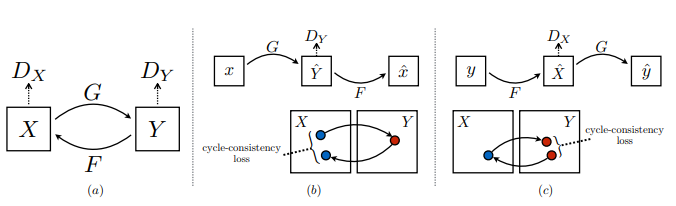


In [85]:
import os
os.environ['KERAS_BACKEND']='theano' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [89]:
import os
os.environ['KERAS_BACKEND']='theano' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
# LeakyReLU has moved from keras.layers.advanced_activations to keras.layers
from keras.layers import LeakyReLU, Activation
# Instead of importing 'relu' directly from keras.activations, import Activation
# and use it with 'relu' as the argument when needed.
from keras.initializers import RandomNormal

In [91]:
# Weights initializations
# bias are initailized as 0
import tensorflow as tf  # Import TensorFlow if not already imported

def __conv_init(a):
    print("conv_init", a)
    # Use tf.keras.initializers.RandomNormal instead of keras.initializers.RandomNormal
    k = tf.keras.initializers.RandomNormal(0, 0.02)(a)  # for convolution kernel
    k.conv_weight = True
    return k

# Use tf.keras.initializers.RandomNormal instead of keras.initializers.RandomNormal
conv_init = tf.keras.initializers.RandomNormal(0, 0.02)
gamma_init = tf.keras.initializers.RandomNormal(1., 0.02) # for batch normalization

In [93]:
import os
import keras.backend as K

# HACK speed up theano
# Use K.backend() instead of K._BACKEND
if K.backend() == 'theano':
    import keras.backend.theano_backend as theano_backend  # Assuming this import is still relevant
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel # Assuming this assignment is still relevant

In [110]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer=conv_init, *a, **k)

def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer=gamma_init)

def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """
    if channel_first:
        input_a = Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name='First')(_)
    _ = LeakyReLU(alpha=0.2)(_)

    for layer in range(1, max_layers):
        out_feat = ndf * min(2 ** layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same",
                   use_bias=False, name='pyramid.{0}'.format(layer)
                   ) (_)
        _ = batchnorm()(_, training=1)
        _ = LeakyReLU(alpha=0.2)(_)

    out_feat = ndf * min(2 ** max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4, use_bias=False, name='pyramid_last')(_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)

    # final layer
    _ = ZeroPadding2D(1)(_)
    # The potential issue was in calculation of padding or strides with '/'
    # Replace '/' with '//' for floor division in the arguments below
    _ = conv2d(1, kernel_size=4, name='final', # Remove .format(out_feat, 1) as it's unnecessary
               activation="sigmoid" if use_sigmoid else None)(_)
    return Model(inputs=[input_a], outputs=_)

In [111]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):
    max_nf = 8*ngf
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,
                            name = 'convt.{0}'.format(s))(x)
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x

    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [112]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
λ = 10 if use_lsgan else 100

loadSize = 143
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.


TypeError: unsupported operand type(s) for /: 'Dimension' and 'int', please use // instead

In [113]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()
from keras.optimizers import RMSprop, SGD, Adam
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB
loss_G = loss_GA+loss_GB+λ*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)


ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [114]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"
data = "horse2zebra"
train_A = load_data('CycleGAN/{}/trainA/*.jpg'.format(data))
train_B = load_data('CycleGAN/{}/trainB/*.jpg'.format(data))

assert len(train_A) and len(train_B)
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None
    while True:
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)
import time
from IPython.display import clear_output
t0 = time.time()
niter = 150
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 50
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)

while epoch < niter:
    epoch, A, B = next(train_batch)
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters,
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A,B)
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0


AssertionError: 

Courtesy: https://www.geeksforgeeks.org/wasserstein-generative-adversarial-networks-wgans-convergence-and-optimization/

####**8) WasserStein GAN:**

- WGANs use deep neural networks for both the generator and discriminator, with the key difference from GANs being the loss function and gradient penalty.
- They address mode collapse by using the Wasserstein distance, offering a smoother and more meaningful measure of distribution differences.
https://media.geeksforgeeks.org/wp-content/uploads/20231214151915/Screenshot-from-2023-12-14-15-19-01.png


**Benefits of WGAN over GAN:**

- Stability: WGANs are more stable due to the Wasserstein distance, which is continuous and differentiable, allowing smoother gradient descent.
- Critic Training: The critic (discriminator) can be trained until optimality without destabilizing the model.
- No Mode Collapse: WGANs show no evidence of mode collapse.
- No Local Minima: WGANs are less likely to get stuck in local minima during training.
- Flexibility: WGANs offer more flexibility in network architecture, allowing changes in weight clipping and generator structures as needed.


In [121]:

!pip install tensorflow

# Import necessary modules
from tensorflow import keras
#In newer versions of tensorflow, the constraints are directly under keras,
#and not in the constraints folder. So change your import statement as follows:
from keras import constraints
from tensorflow.keras import backend as K
# Use 'keras.optimizers' instead of 'tensorflow.keras.optimizers'
from keras.optimizers import Adam # This imports Adam from keras.optimizers.

In [124]:
#1) imports

# Instead of this:
# from keras.constraints import Constraint
# Import this:

from keras import constraints

In [125]:
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
#from keras.constraints import Constraint # Old import
from keras import constraints # New import
from matplotlib import pyplot

In [126]:
#2) Define Wasserstein loss function

def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [131]:
#3) Generate images

# load images from the dataset
def load_real_samples():
    (trainX, trainy), (_, _) = load_data()
    selected_ix = trainy == 5
    X = trainX[selected_ix]
    X = expand_dims(X, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = -ones((n_samples, 1))
    return X, y

In [132]:
# 4): Generate Samples
# select real samples
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = -ones((n_samples, 1))
    return X, y

In [155]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.0
    Uninstalling tensorflow-2.13.0:
      Successfully uninstalled tensorflow-2.13.0


In [156]:
# 5): Define Critic and Discriminator Model
# clip model
from keras import constraints
class ClipConstraint(constraints.Constraint): # Added constraints to Constraint
   def __init__(self, clip_value):
    self.clip_value = clip_value
   def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)

# critic model
def define_critic(in_shape=(28,28,1)):
    init = RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    model = Sequential()
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1))
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [157]:
# 6) Define Generator Model
def define_generator(latent_dim):

    init = RandomNormal(stddev=0.03)
    # define model
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
    return model


In [158]:
#7): Update the generator

def define_gan(generator, critic):
    # make weights in the critic not trainable
    for layer in critic.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(critic)
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [159]:
#8) Generate Fake Samples
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# fake examples
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = ones((n_samples, 1))
    return X, y

In [160]:
#9) Model Training

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
    # number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # number of training iterations
    n_steps = bat_per_epo * n_epochs
    # size of half a batch of samples
    half_batch = int(n_batch / 2)

    c1_hist, c2_hist, g_hist = list(), list(), list()

    for i in range(n_steps):
        # update the critic
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = -ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_hist.append(g_loss)
        print('&gt;%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
        # evaluate the model performance every 'epoch'
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)


In [161]:
#10) Visualization
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(10 * 10):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename1 = 'plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='crit_real')
    pyplot.plot(d2_hist, label='crit_fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.savefig('line_plot_loss.png')
    pyplot.close()


In [162]:
latent_dim = 50
critic = define_critic()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, critic)
dataset = load_real_samples()
print(dataset.shape)
train(generator, critic, gan_model, dataset, latent_dim)

AttributeError: module 'keras.src.backend' has no attribute 'RandomGenerator'

In [144]:
import os
import imageio

imgdir = '/content/'

gif_files = [file for file in os.listdir(imgdir) if file.startswith('plot_')]

gif_files.sort()

images = []
for image_file in gif_files:
    image_path = os.path.join(imgdir, image_file)
    images.append(imageio.imread(image_path))

imageio.mimsave('output.gif', images,format=&quot;GIF&quot;, fps=2)


SyntaxError: invalid syntax (<ipython-input-144-3ffd78812a9c>, line 15)